# Data before preprocessing/ original dataset

Load important libraries

In [ ]:
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.offline import plot
import plotly.graph_objs as go

from sklearn.tree import DecisionTreeClassifier, plot_tree

import graphviz
from sklearn.tree import export_graphviz

from sklearn.metrics import confusion_matrix

from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

import seaborn as sns

import plotly.graph_objects as go

np.random.seed(42)

In [ ]:
from google.colab import files
uploaded = files.upload()

import io
df_original = pd.read_csv(io.BytesIO(uploaded['AB_NYC_2019.csv']))

Saving AB_NYC_2019.csv to AB_NYC_2019 (1).csv


## Exploring the dataset

### The dataset

In [ ]:
display(df_original)

id  ... availability_365
0          2539  ...              365
1          2595  ...              355
2          3647  ...              365
3          3831  ...              194
4          5022  ...                0
...         ...  ...              ...
48890  36484665  ...                9
48891  36485057  ...               36
48892  36485431  ...               27
48893  36485609  ...                2
48894  36487245  ...               23

[48895 rows x 16 columns]

### Select the label and the features

Since we want to predict prices, we choose the column 'price' to be our label.

In [ ]:
label = ['price']

We have several features indicating location, thus we drop some of them. For example, since we already have the neighborhood group, we will drop 'neighbourhood',	'latitude' and 'longitude'.

We also drop columns 'id', 'name', 'host id', 'host name' and 'last review'.

In [ ]:
feature_names = ['neighbourhood_group', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

Thus our dataset becomes:

In [ ]:
df_original = df_original[feature_names+label]

In [ ]:
display(df_original)

neighbourhood_group        room_type  ...  availability_365  price
0                Brooklyn     Private room  ...               365    149
1               Manhattan  Entire home/apt  ...               355    225
2               Manhattan     Private room  ...               365    150
3                Brooklyn  Entire home/apt  ...               194     89
4               Manhattan  Entire home/apt  ...                 0     80
...                   ...              ...  ...               ...    ...
48890            Brooklyn     Private room  ...                 9     70
48891            Brooklyn     Private room  ...                36     40
48892           Manhattan  Entire home/apt  ...                27    115
48893           Manhattan      Shared room  ...                 2     55
48894           Manhattan     Private room  ...                23     90

[48895 rows x 8 columns]

### Dimensions of the dataset

In [ ]:
df_original.shape

(48895, 8)

### Features types

In [ ]:
df_original.dtypes

neighbourhood_group                object
room_type                          object
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
price                               int64
dtype: object

## Preliminary statistics

In [ ]:
# stat about the data
df_original_stat = df_original.describe()

In [ ]:
display(df_original_stat)

minimum_nights  number_of_reviews  ...  availability_365         price
count    48895.000000       48895.000000  ...      48895.000000  48895.000000
mean         7.029962          23.274466  ...        112.781327    152.720687
std         20.510550          44.550582  ...        131.622289    240.154170
min          1.000000           0.000000  ...          0.000000      0.000000
25%          1.000000           1.000000  ...          0.000000     69.000000
50%          3.000000           5.000000  ...         45.000000    106.000000
75%          5.000000          24.000000  ...        227.000000    175.000000
max       1250.000000         629.000000  ...        365.000000  10000.000000

[8 rows x 6 columns]

### Distribution of the features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96b51c9be0>,
      dtype=object)

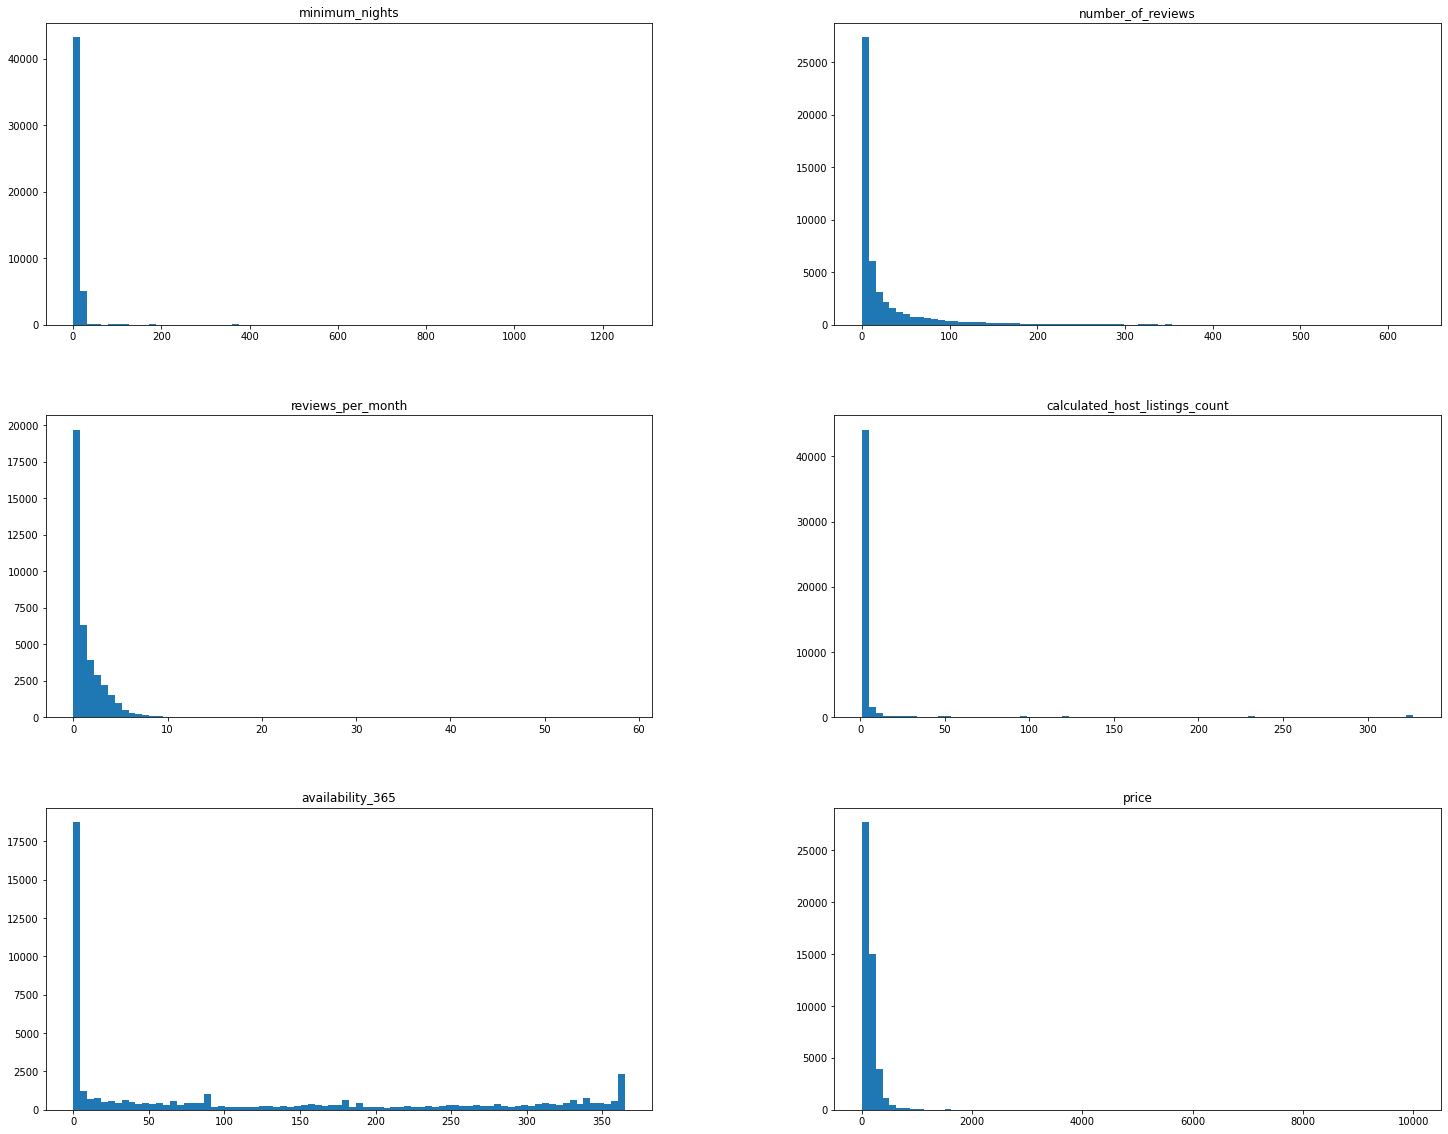

In [ ]:
df_original.hist(grid = False, figsize= (25,20), bins= 80)

For some selected features we the following distributions

In [ ]:
numeric_features = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',  'calculated_host_listings_count', 'availability_365']

for feature in numeric_features:
  fig = px.histogram(df_original, x=feature, color_discrete_sequence=['indianred'], marginal="box")
  fig.update_layout(height=300, margin=dict(l=15, r=15, t=0, b=0))
  fig.show()

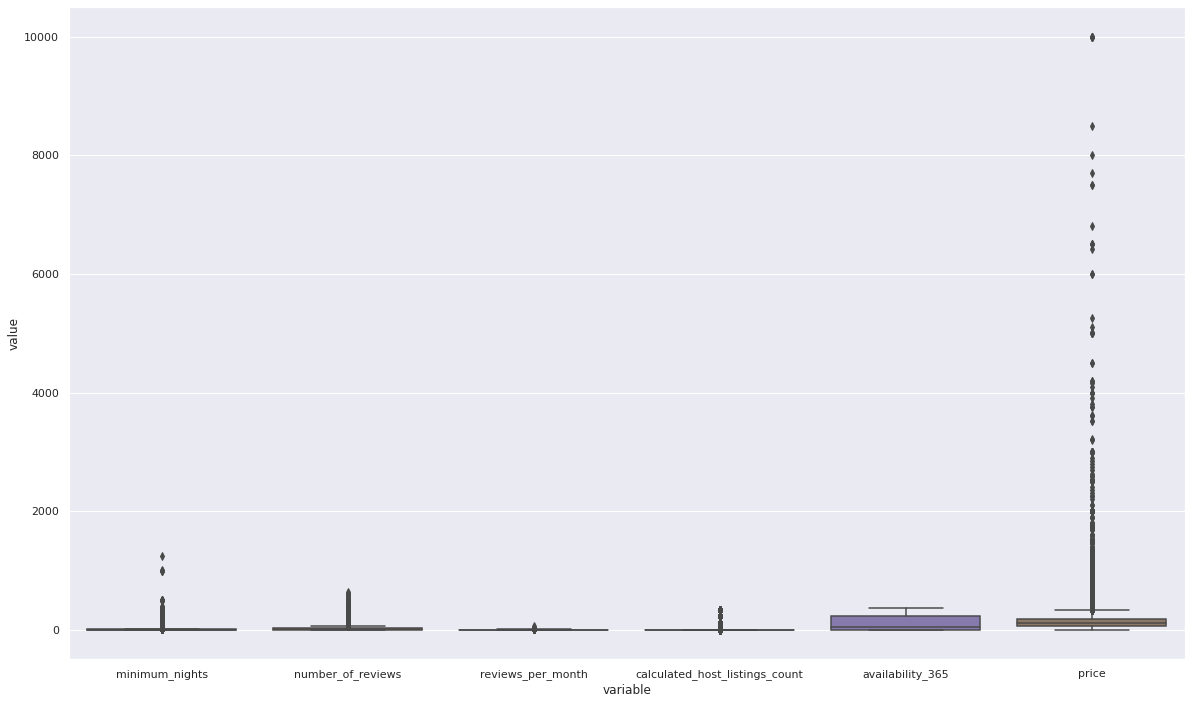

In [ ]:
sns.set()

plt.figure(figsize=(20, 12))
sns.boxplot(x="variable", y="value", data=pd.melt(df_original.iloc[:, 2:]))
plt.show()

### Extreme values

Using boxplots, outliers are data points that lies above the upper limit (beacuse all our numeric feautres are $\geq 0$) where the formula for the upper limit is given by: $\quad Q_3 + 1.5$  $IQR ; \quad IQR = Q_3 - Q_1$

From the above boxplots and outliers definition, all numeric features in our dataset have outliers except availability_365.

In [ ]:
# function to give outliers for any dataset

def outliers(dataframe):
  upperLimit = []
  percentOutliers = []
  column_names = list(dataframe.columns)
  numeric_column_name = []

  numericType = ('int64' or 'float64')

  for i in range(0,len(column_names)):
    if dataframe.iloc[:, i].dtypes == numericType:
      upperlim = dataframe.iloc[:, i].quantile(.75) + 1.5 * (dataframe.iloc[:, i].quantile(.75) - dataframe.iloc[:, i].quantile(.25))
      upperLimit.append(upperlim)
      num_outliers = len(dataframe[dataframe.iloc[:, i] >= upperlim])
      percent_outliers = round((num_outliers / len(dataframe)) * 100, 2)
      percentOutliers.append(percent_outliers)
      numeric_column_name.append(column_names[i])

  outliersdict = {'feature' : numeric_column_name, 'upper limit' : upperLimit, 'percentage of outliers' : percentOutliers}

  return pd.DataFrame(outliersdict)

Then the table of outliers is

In [ ]:
outliers(df_original)

feature  upper limit  percentage of outliers
0                  minimum_nights         11.0                   13.58
1               number_of_reviews         58.5                   12.31
2  calculated_host_listings_count          3.5                   14.48
3                availability_365        567.5                    0.00
4                           price        334.0                    6.09

As shown in the outliers table, the number of extreme values makes-up more than 5% of our data. Hence, we can no longer catogorize them as outliers, instead they are extreme values that add variance to the dataset.

### Correlation

In [ ]:
# scatterplot matrix
mat_price = px.scatter_matrix(df_original, dimensions=numeric_features, color='price')
mat_price.update_layout(autosize=False,width=13 * 100,height=13 * 100,margin=dict(l=0, r=0, t=0, b=0))
mat_price.show()

## Missing values

counting the number of values in each column helps detecting missing values in the data set

In [ ]:
# count the number of values in each column
df_original.count()

neighbourhood_group               48895
room_type                         48895
minimum_nights                    48895
number_of_reviews                 48895
reviews_per_month                 38843
calculated_host_listings_count    48895
availability_365                  48895
price                             48895
dtype: int64

In [ ]:
# count the total NaN values
num_NaN = df_original.isnull().sum()
num_NaN

# or
# df_original[num_NaN==True].count()

neighbourhood_group                   0
room_type                             0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
price                                 0
dtype: int64

We have more than 10 thousand of missing values in only the 'reviews_per_month' feature.

### Price equal zero

We check for prices = 0 because renting property for free doesn't seem rational.

In [ ]:
(df_original['price'] == 0).sum()

11

There are eleven data points that have price = 0.

In [ ]:
display(df_original[df_original['price']==0])

neighbourhood_group        room_type  ...  availability_365  price
23161            Brooklyn     Private room  ...                28      0
25433               Bronx     Private room  ...               127      0
25634            Brooklyn     Private room  ...                 0      0
25753            Brooklyn     Private room  ...                 0      0
25778            Brooklyn  Entire home/apt  ...                73      0
25794            Brooklyn     Private room  ...               176      0
25795            Brooklyn     Private room  ...               232      0
25796            Brooklyn     Private room  ...               222      0
26259           Manhattan  Entire home/apt  ...                 0      0
26841            Brooklyn      Shared room  ...               333      0
26866            Brooklyn      Shared room  ...               139      0

[11 rows x 8 columns]

# Preprocessing / Cleaning

In [ ]:
df = df_original.copy()

In [ ]:
# set display option
pd.set_option('display.max_rows', 100, 'display.max_columns', None)

## Data types

First we start by converting data to their apropriate type

In [ ]:
categorical_columns =['neighbourhood_group',	'room_type']
for feature in categorical_columns:
  df[feature] = df[feature].astype('category')

In [ ]:
display(df.dtypes)

neighbourhood_group               category
room_type                         category
minimum_nights                       int64
number_of_reviews                    int64
reviews_per_month                  float64
calculated_host_listings_count       int64
availability_365                     int64
price                                int64
dtype: object

## Duplicates

In [ ]:
df[df.duplicated()]

neighbourhood_group        room_type  minimum_nights  number_of_reviews  \
1160             Brooklyn     Private room               7                  0   
2038            Manhattan     Private room              30                  0   
2339            Manhattan  Entire home/apt               3                  0   
2404               Queens     Private room               1                  0   
2502            Manhattan  Entire home/apt               3                  0   
...                   ...              ...             ...                ...   
48768            Brooklyn     Private room               2                  0   
48772            Brooklyn     Private room              30                  0   
48779            Brooklyn     Private room               3                  0   
48786              Queens     Private room               1                  0   
48810           Manhattan     Private room              30                  0   

       reviews_per_month  calculated_host_listings_count  availability_365  \
1160                 NaN                               1                 0   
2038                 NaN                               2               365   
2339                 NaN                               1                 0   
2404                 NaN                               1                 0   
2502                 NaN                               1                 0   
...                  ...                             ...               ...   
48768                NaN                               1                 6   
48772                NaN                               1                44   
48779                NaN                               1                 0   
48786                NaN                               2               180   
48810                NaN                               1                90   

       price  
1160      75  
2038     100  
2339     200  
2404      60  
2502     200  
...      ...  
48768     65  
48772     35  
48779     50  
48786     75  
48810     75  

[3215 rows x 8 columns]

We have 3215 diplicated rows. We drop those rows.

In [ ]:
df = df.drop_duplicates()

In [ ]:
display(df)

neighbourhood_group        room_type  minimum_nights  number_of_reviews  \
0                Brooklyn     Private room               1                  9   
1               Manhattan  Entire home/apt               1                 45   
2               Manhattan     Private room               3                  0   
3                Brooklyn  Entire home/apt               1                270   
4               Manhattan  Entire home/apt              10                  9   
...                   ...              ...             ...                ...   
48890            Brooklyn     Private room               2                  0   
48891            Brooklyn     Private room               4                  0   
48892           Manhattan  Entire home/apt              10                  0   
48893           Manhattan      Shared room               1                  0   
48894           Manhattan     Private room               7                  0   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   0.21                               6               365   
1                   0.38                               2               355   
2                    NaN                               1               365   
3                   4.64                               1               194   
4                   0.10                               1                 0   
...                  ...                             ...               ...   
48890                NaN                               2                 9   
48891                NaN                               2                36   
48892                NaN                               1                27   
48893                NaN                               6                 2   
48894                NaN                               1                23   

       price  
0        149  
1        225  
2        150  
3         89  
4         80  
...      ...  
48890     70  
48891     40  
48892    115  
48893     55  
48894     90  

[45680 rows x 8 columns]

### Remove price = 0

In [ ]:
df = df[df['price'] != 0]

In [ ]:
df.reset_index(inplace=True)

In [ ]:
display(df)

index neighbourhood_group        room_type  minimum_nights  \
0          0            Brooklyn     Private room               1   
1          1           Manhattan  Entire home/apt               1   
2          2           Manhattan     Private room               3   
3          3            Brooklyn  Entire home/apt               1   
4          4           Manhattan  Entire home/apt              10   
...      ...                 ...              ...             ...   
45664  48890            Brooklyn     Private room               2   
45665  48891            Brooklyn     Private room               4   
45666  48892           Manhattan  Entire home/apt              10   
45667  48893           Manhattan      Shared room               1   
45668  48894           Manhattan     Private room               7   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                      9               0.21                               6   
1                     45               0.38                               2   
2                      0                NaN                               1   
3                    270               4.64                               1   
4                      9               0.10                               1   
...                  ...                ...                             ...   
45664                  0                NaN                               2   
45665                  0                NaN                               2   
45666                  0                NaN                               1   
45667                  0                NaN                               6   
45668                  0                NaN                               1   

       availability_365  price  
0                   365    149  
1                   355    225  
2                   365    150  
3                   194     89  
4                     0     80  
...                 ...    ...  
45664                 9     70  
45665                36     40  
45666                27    115  
45667                 2     55  
45668                23     90  

[45669 rows x 9 columns]

## Remark

Before moving on to transforming all features to numeric we do classification (So that we don't alter the code).

Since we are considering classification dependent on each market, we need to build another dataframe that accounts for different markets. We start by looking at a grouped dataframe that shows statistics for each market.

In [ ]:
# group data by neighbourhood group and room type
grouped_stat = df.groupby(['neighbourhood_group', 'room_type']).describe()

In [ ]:
# box plot for price
box_price = px.box(df, x = 'neighbourhood_group', y = 'price', color="room_type")
box_price.show()

In order to build this dataframe, we start by extracting sub-dataframes for each market. Then, we calculate three thresholds (Q1, Q3 and upper fence) dependent on each market. These thresholds will be used for classification.

In [ ]:
# for loop to make sub dataframes accounting for different markets
uni_neighbourhood_group = np.array(df['neighbourhood_group'].unique())
uni_room_type = np.array(df['room_type'].unique())

dataframes_dict = {}
for neighbourhood_group in uni_neighbourhood_group:
    for room_type in uni_room_type:
        dataframes_dict[format(neighbourhood_group)+'_'+format(room_type)] = df[(df['neighbourhood_group'] == neighbourhood_group) & (df['room_type'] == room_type)]

We've created a dictionary of dataframes.

Now, to be able to see this dictionary as a table we type the following code,

In [ ]:
Key = []
Type =[]
Size = []
Value =[]
for key, value in dataframes_dict.items():
  Key.append(key)
  if isinstance(dataframes_dict[key], pd.DataFrame):
      t = 'DataFrame'
      Type.append(t)
  Size.append(dataframes_dict[key].shape)
  Value.append(value)

dataframes_dict_table = pd.DataFrame({"Key" : Key, "Type" : Type, "Size" : Size, "Value" : Value})

Next, we move on to calculate the thresholds for each market.

In [ ]:
# calculate 3 threshholds for each market
thresholds_dict = {}
for key in dataframes_dict:
    thresholds_dict[format(key)] = [dataframes_dict[key]['price'].quantile(.25), dataframes_dict[key]['price'].quantile(.75), dataframes_dict[key]['price'].quantile(.75) + 1.5 * (dataframes_dict[key]['price'].quantile(.75) - dataframes_dict[key]['price'].quantile(.25))]

Similar to the previuos code, we want to display the dictionary as a table.

In [ ]:
Keys = []
Values =[]
for key, value in thresholds_dict.items():
  Keys.append(key)
  Values.append(value)

thresholds_dict_table = pd.DataFrame({"Market" : Keys, "Thresholds" : Values})

The following function takes two arguments. The first argument is a Series of prices, and the second argument is a list of thresholds. The returned value is a Series of categorical labels.

In [ ]:
# define classifying function
def classify(price, price_ranges):
    if len(price_ranges) == 2:
        if (price < price_ranges[0]):
            return 'cheap'
        elif (price >= price_ranges[0]) & (price < price_ranges[1]):
            return 'medium'
        elif (price >= price_ranges[1]):
            return 'expensive'
        else:
            return 'Error'

    elif len(price_ranges) == 3:
        if (price < price_ranges[0]):
            return 'cheap'
        elif (price >= price_ranges[0]) & (price < price_ranges[1]):
            return 'medium'
        elif (price >= price_ranges[1]) & (price < price_ranges[2]):
            return 'expensive'
        elif (price >= price_ranges[2]):
            return 'very expensive'
        else:
            return 'Error'

    elif len(price_ranges) == 4:
        if (price < price_ranges[0]):
            return 'very cheap'
        elif (price >= price_ranges[0]) & (price < price_ranges[1]):
            return 'cheap'
        elif (price >= price_ranges[1]) & (price < price_ranges[2]):
            return 'medium'
        elif (price >= price_ranges[2]) & (price < price_ranges[3]):
            return 'expensive'
        elif (price >= price_ranges[3]):
            return 'very expensive'
        else:
            return 'Error'

    else:
        print('length should be either 3 or 5')

For classifying the data in general, we use the above function on the price feature where the thresholds are [ $Q_1, \ Q_3, \ Q_3 + 1.5 \ IQR$ ].

In [ ]:
df['general_class'] = df['price'].apply(classify, price_ranges=[df['price'].quantile(.25), df['price'].quantile(.75), df['price'].quantile(.75) +1.5 * (df['price'].quantile(.75) - df['price'].quantile(.25)) ])

In [ ]:
display(df)

index neighbourhood_group        room_type  minimum_nights  \
0          0            Brooklyn     Private room               1   
1          1           Manhattan  Entire home/apt               1   
2          2           Manhattan     Private room               3   
3          3            Brooklyn  Entire home/apt               1   
4          4           Manhattan  Entire home/apt              10   
...      ...                 ...              ...             ...   
45664  48890            Brooklyn     Private room               2   
45665  48891            Brooklyn     Private room               4   
45666  48892           Manhattan  Entire home/apt              10   
45667  48893           Manhattan      Shared room               1   
45668  48894           Manhattan     Private room               7   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                      9               0.21                               6   
1                     45               0.38                               2   
2                      0                NaN                               1   
3                    270               4.64                               1   
4                      9               0.10                               1   
...                  ...                ...                             ...   
45664                  0                NaN                               2   
45665                  0                NaN                               2   
45666                  0                NaN                               1   
45667                  0                NaN                               6   
45668                  0                NaN                               1   

       availability_365  price general_class  
0                   365    149        medium  
1                   355    225     expensive  
2                   365    150        medium  
3                   194     89        medium  
4                     0     80        medium  
...                 ...    ...           ...  
45664                 9     70        medium  
45665                36     40         cheap  
45666                27    115        medium  
45667                 2     55         cheap  
45668                23     90        medium  

[45669 rows x 10 columns]

Now we do the same thing for classifying the data but considering different markets.

In [ ]:
# classification considering each market
df_market_dict = {}
for dataframe in dataframes_dict.keys():
    sub_dataframe = dataframes_dict[dataframe].copy()
    sub_dataframe['market_class'] = -1
    sub_dataframe['market_class'] = sub_dataframe['price'].apply(classify, price_ranges= thresholds_dict[dataframe])
    df_market_dict[format(dataframe)] = sub_dataframe


In [ ]:
# put dataframes in a list to be merged
frames_to_merge = []
for dataframe in df_market_dict.keys():
    frames_to_merge.append(df_market_dict[dataframe])

In [ ]:
# merge data
df_market = pd.concat(frames_to_merge)

In [ ]:
# sort dataframe by index
df_market = df_market.sort_index()

In [ ]:
## add the by-market labels to the original dataframe
df['market_class'] = df_market['market_class']

In [ ]:
display(df)

index neighbourhood_group        room_type  minimum_nights  \
0          0            Brooklyn     Private room               1   
1          1           Manhattan  Entire home/apt               1   
2          2           Manhattan     Private room               3   
3          3            Brooklyn  Entire home/apt               1   
4          4           Manhattan  Entire home/apt              10   
...      ...                 ...              ...             ...   
45664  48890            Brooklyn     Private room               2   
45665  48891            Brooklyn     Private room               4   
45666  48892           Manhattan  Entire home/apt              10   
45667  48893           Manhattan      Shared room               1   
45668  48894           Manhattan     Private room               7   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                      9               0.21                               6   
1                     45               0.38                               2   
2                      0                NaN                               1   
3                    270               4.64                               1   
4                      9               0.10                               1   
...                  ...                ...                             ...   
45664                  0                NaN                               2   
45665                  0                NaN                               2   
45666                  0                NaN                               1   
45667                  0                NaN                               6   
45668                  0                NaN                               1   

       availability_365  price general_class    market_class  
0                   365    149        medium  very expensive  
1                   355    225     expensive          medium  
2                   365    150        medium       expensive  
3                   194     89        medium           cheap  
4                     0     80        medium           cheap  
...                 ...    ...           ...             ...  
45664                 9     70        medium          medium  
45665                36     40         cheap           cheap  
45666                27    115        medium           cheap  
45667                 2     55         cheap          medium  
45668                23     90        medium          medium  

[45669 rows x 11 columns]

## Transform categorical features to numerical

In [ ]:
# define categorical features
cat_feature_names = feature_names[:2]

In [ ]:
cat_feature_names

['neighbourhood_group', 'room_type']

In [ ]:
for feature in cat_feature_names:
  df = pd.concat([df, pd.get_dummies(df[feature], prefix=feature)], axis=1).drop([feature], axis=1)

In [ ]:
display(df)

index  minimum_nights  number_of_reviews  reviews_per_month  \
0          0               1                  9               0.21   
1          1               1                 45               0.38   
2          2               3                  0                NaN   
3          3               1                270               4.64   
4          4              10                  9               0.10   
...      ...             ...                ...                ...   
45664  48890               2                  0                NaN   
45665  48891               4                  0                NaN   
45666  48892              10                  0                NaN   
45667  48893               1                  0                NaN   
45668  48894               7                  0                NaN   

       calculated_host_listings_count  availability_365  price general_class  \
0                                   6               365    149        medium   
1                                   2               355    225     expensive   
2                                   1               365    150        medium   
3                                   1               194     89        medium   
4                                   1                 0     80        medium   
...                               ...               ...    ...           ...   
45664                               2                 9     70        medium   
45665                               2                36     40         cheap   
45666                               1                27    115        medium   
45667                               6                 2     55         cheap   
45668                               1                23     90        medium   

         market_class  neighbourhood_group_Bronx  \
0      very expensive                          0   
1              medium                          0   
2           expensive                          0   
3               cheap                          0   
4               cheap                          0   
...               ...                        ...   
45664          medium                          0   
45665           cheap                          0   
45666           cheap                          0   
45667          medium                          0   
45668          medium                          0   

       neighbourhood_group_Brooklyn  neighbourhood_group_Manhattan  \
0                                 1                              0   
1                                 0                              1   
2                                 0                              1   
3                                 1                              0   
4                                 0                              1   
...                             ...                            ...   
45664                             1                              0   
45665                             1                              0   
45666                             0                              1   
45667                             0                              1   
45668                             0                              1   

       neighbourhood_group_Queens  neighbourhood_group_Staten Island  \
0                               0                                  0   
1                               0                                  0   
2                               0                                  0   
3                               0                                  0   
4                               0                                  0   
...                           ...                                ...   
45664                           0                                  0   
45665                           0                                  0   
45666                           0                                  0   
45667              

In [ ]:
df = df.drop('index', axis='columns')

In [ ]:
display(df.describe())

minimum_nights  number_of_reviews  reviews_per_month  \
count    45669.000000       45669.000000       38168.000000   
mean         7.255797          24.887648           1.396163   
std         21.137269          45.659713           1.685762   
min          1.000000           0.000000           0.010000   
25%          2.000000           1.000000           0.210000   
50%          3.000000           6.000000           0.750000   
75%          5.000000          26.000000           2.060000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365         price  \
count                    45669.000000      45669.000000  45669.000000   
mean                         7.360091        119.350084    153.730145   
std                         33.657272        132.118651    246.039877   
min                          1.000000          0.000000     10.000000   
25%                          1.000000          0.000000     69.000000   
50%                          1.000000         61.000000    109.000000   
75%                          2.000000        241.000000    175.000000   
max                        327.000000        365.000000  10000.000000   

       neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
count               45669.000000                  45669.000000   
mean                    0.023692                      0.408702   
std                     0.152090                      0.491599   
min                     0.000000                      0.000000   
25%                     0.000000                      0.000000   
50%                     0.000000                      0.000000   
75%                     0.000000                      1.000000   
max                     1.000000                      1.000000   

       neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
count                   45669.000000                45669.000000   
mean                        0.438919                    0.120541   
std                         0.496261                    0.325597   
min                         0.000000                    0.000000   
25%                         0.000000                    0.000000   
50%                         0.000000                    0.000000   
75%                         1.000000                    0.000000   
max                         1.000000                    1.000000   

       neighbourhood_group_Staten Island  room_type_Entire home/apt  \
count                       45669.000000               45669.000000   
mean                            0.008146                   0.525170   
std                             0.089885                   0.499372   
min                             0.000000                   0.000000   
25%                             0.000000                   0.000000   
50%                             0.000000                   1.000000   
75%                             0.000000                   1.000000   
max                             1.000000                   1.000000   

       room_type_Private room  room_type_Shared room  
count            45669.000000           45669.000000  
mean                 0.450043               0.024787  
std                  0.497503               0.155477  
min                  0.000000               0.000000  
25%                  0.000000               0.000000  
50%                  0.000000               0.000000  
75%                  1.000000               0.000000  
max                  1.000000               1.000000

## Handling missing values

In [ ]:
df_Labels = df[['price', 'general_class', 'market_class']]

In [ ]:
display(df_Labels)

price general_class    market_class
0        149        medium  very expensive
1        225     expensive          medium
2        150        medium       expensive
3         89        medium           cheap
4         80        medium           cheap
...      ...           ...             ...
45664     70        medium          medium
45665     40         cheap           cheap
45666    115        medium           cheap
45667     55         cheap          medium
45668     90        medium          medium

[45669 rows x 3 columns]

In [ ]:
df = df.drop(columns= ['general_class', 'market_class'])

In [ ]:
# check which columns have missing values
columns_with_na = list(df.columns[df.describe().loc['count', :] < len(df.index)])

In [ ]:
display(columns_with_na)

['reviews_per_month']

The above feature have missing values in it. Let's add a new column which indicate what values in this column were missing (missingness features):

In [ ]:
df["reviews_per_month_missing"] = df['reviews_per_month'].isnull().astype("uint8")

Now we reorder our columns

In [ ]:
df = df.drop(columns='price')
df['price'] = df_Labels['price']

In [ ]:
df['general_class'] = df_Labels['general_class']
df['market_class'] = df_Labels['market_class']

In [ ]:
display(df)

minimum_nights  number_of_reviews  reviews_per_month  \
0                   1                  9               0.21   
1                   1                 45               0.38   
2                   3                  0                NaN   
3                   1                270               4.64   
4                  10                  9               0.10   
...               ...                ...                ...   
45664               2                  0                NaN   
45665               4                  0                NaN   
45666              10                  0                NaN   
45667               1                  0                NaN   
45668               7                  0                NaN   

       calculated_host_listings_count  availability_365  \
0                                   6               365   
1                                   2               355   
2                                   1               365   
3                                   1               194   
4                                   1                 0   
...                               ...               ...   
45664                               2                 9   
45665                               2                36   
45666                               1                27   
45667                               6                 2   
45668                               1                23   

       neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                              0                             1   
1                              0                             0   
2                              0                             0   
3                              0                             1   
4                              0                             0   
...                          ...                           ...   
45664                          0                             1   
45665                          0                             1   
45666                          0                             0   
45667                          0                             0   
45668                          0                             0   

       neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                                  0                           0   
1                                  1                           0   
2                                  1                           0   
3                                  0                           0   
4                                  1                           0   
...                              ...                         ...   
45664                              0                           0   
45665                              0                           0   
45666                              1                           0   
45667                              1                           0   
45668                              1                           0   

       neighbourhood_group_Staten Island  room_type_Entire home/apt  \
0                                      0                          0   
1                                      0                          1   
2                                      0                          0   
3                                      0                          1   
4                                      0                          1   
...                                  ...                        ...   
45664                                  0                          0   
45665                                  0                          0   
45666                                  0                          1   
45667                                  0                          0   
45668                                  0                          0   

       room_type_Private room  room_type_Shared room  \
0                     

### Imputation with $k$-NN regressor

In [ ]:
df_learn, df_test = train_test_split(df, test_size=0.2)
df_train, df_validation = train_test_split(df_learn, test_size=0.25)

In [ ]:
from  sklearn.neighbors import KNeighborsRegressor

In [ ]:
bad_columns = columns_with_na + ['price', 'general_class', 'market_class']

is_missing_train = df_train[columns_with_na].isnull().iloc[:,0]# select the rows of the column 'reviews_per_month' that have NaN (one column)

knn_reg_imputer = KNeighborsRegressor(n_neighbors=5)

X_not_missing_train = df_train[is_missing_train == False].drop(bad_columns, axis=1).values  # select the features from the training data that doesn't have NaN & drop bad_columns
y_not_missing_train = df_train[is_missing_train == False][columns_with_na].values  # select the target column to predict ('reviews_per_month') from the training data that doesn't have NaN

knn_reg_imputer.fit(X_not_missing_train, y_not_missing_train)

is_missing_validation = df_validation[columns_with_na].isnull().iloc[:,0]

is_missing_test = df_test[columns_with_na].isnull().iloc[:,0]

X_missing_train = df_train[is_missing_train == True].drop(bad_columns, axis=1).values # select the features from the training data that have missing values

X_missing_validation =  df_validation[is_missing_validation == True].drop(bad_columns, axis=1).values

X_missing_test = df_test[is_missing_test == True].drop(bad_columns, axis=1).values

if X_missing_train.shape[0] > 0: # if there are rows that have missing values in this sub dataset
   yhat_missing_train = knn_reg_imputer.predict(X_missing_train) # predict the values of NaN
   df_train.loc[is_missing_train, columns_with_na] = yhat_missing_train # overwrite NaN in these rows with the predicted values

if X_missing_validation.shape[0] > 0:
   yhat_missing_validation = knn_reg_imputer.predict(X_missing_validation)
   df_validation.loc[is_missing_validation, columns_with_na] = yhat_missing_validation

if X_missing_test.shape[0] > 0:
   yhat_missing_test = knn_reg_imputer.predict(X_missing_test)
   df_test.loc[is_missing_test, columns_with_na] = yhat_missing_test

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

Now, we can check if we have any missing values left:

In [ ]:
display(df_train.iloc[:, :-2].columns[df_train.iloc[:, :-2].describe().loc['count', :] < len(df_train.index)])
display(df_validation.iloc[:, :-2].columns[df_validation.iloc[:, :-2].describe().loc['count', :] <  len(df_validation.index)])
display(df_test.iloc[:, :-2].columns[df_test.iloc[:, :-2].describe().loc['count', :] <  len(df_test.index)])

Index([], dtype='object')

Index([], dtype='object')

Index([], dtype='object')

We don't have any missing values. Let's take another look at our dataset after imputation of missing values:

In [ ]:
display(df_train)

minimum_nights  number_of_reviews  reviews_per_month  \
16112               2                  1              0.030   
24717               2                 39              1.910   
20319               2                 12              0.460   
40777               4                  1              0.480   
39856               2                  3              1.030   
...               ...                ...                ...   
39194               2                  7              2.440   
42833              30                  0              0.346   
38216               1                  4              0.850   
42613               1                  0              0.462   
26907               2                 95              5.270   

       calculated_host_listings_count  availability_365  \
16112                               1                 0   
24717                               2               130   
20319                               1                32   
40777                               1                 0   
39856                               1                16   
...                               ...               ...   
39194                               1               104   
42833                               9               200   
38216                               2                29   
42613                               1                66   
26907                               1                48   

       neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
16112                          0                             1   
24717                          0                             1   
20319                          0                             1   
40777                          0                             1   
39856                          0                             1   
...                          ...                           ...   
39194                          0                             0   
42833                          0                             0   
38216                          0                             0   
42613                          0                             1   
26907                          0                             1   

       neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
16112                              0                           0   
24717                              0                           0   
20319                              0                           0   
40777                              0                           0   
39856                              0                           0   
...                              ...                         ...   
39194                              1                           0   
42833                              1                           0   
38216                              1                           0   
42613                              0                           0   
26907                              0                           0   

       neighbourhood_group_Staten Island  room_type_Entire home/apt  \
16112                                  0                          0   
24717                                  0                          1   
20319                                  0                          0   
40777                                  0                          1   
39856                                  0                          1   
...                                  ...                        ...   
39194                                  0                          1   
42833                                  0                          1   
38216                                  0                          1   
42613                                  0                          1   
26907                                  0                          1   

       room_type_Private room  room_type_Shared room  \
16112                 

In [ ]:
display(df_validation)

minimum_nights  number_of_reviews  reviews_per_month  \
19248               3                 10               0.71   
7420               21                  1               0.02   
32824               1                 47               4.64   
29015               2                  2               0.15   
30857               1                 50               4.19   
...               ...                ...                ...   
32175               2                  8               1.06   
26925               2                 21               1.20   
1294                5                  1               0.01   
13587               2                  3               0.08   
11233               1                 49               1.11   

       calculated_host_listings_count  availability_365  \
19248                               1                 8   
7420                                2                 1   
32824                               2               196   
29015                               1                 0   
30857                               1               349   
...                               ...               ...   
32175                               3                62   
26925                               2                28   
1294                                1                 0   
13587                               2                 0   
11233                               1               230   

       neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
19248                          0                             0   
7420                           0                             1   
32824                          0                             0   
29015                          0                             1   
30857                          1                             0   
...                          ...                           ...   
32175                          0                             0   
26925                          0                             1   
1294                           0                             0   
13587                          0                             1   
11233                          0                             0   

       neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
19248                              1                           0   
7420                               0                           0   
32824                              0                           1   
29015                              0                           0   
30857                              0                           0   
...                              ...                         ...   
32175                              1                           0   
26925                              0                           0   
1294                               1                           0   
13587                              0                           0   
11233                              1                           0   

       neighbourhood_group_Staten Island  room_type_Entire home/apt  \
19248                                  0                          0   
7420                                   0                          0   
32824                                  0                          0   
29015                                  0                          1   
30857                                  0                          1   
...                                  ...                        ...   
32175                                  0                          1   
26925                                  0                          0   
1294                                   0                          1   
13587                                  0                          1   
11233                                  0                          0   

       room_type_Private room  room_type_Shared room  \
19248                 

In [ ]:
display(df_test)

minimum_nights  number_of_reviews  reviews_per_month  \
1030                2                197              2.250   
3715                1                 21              0.360   
7487                3                 30              0.590   
29615               3                 10              0.790   
34090               1                  9              2.870   
...               ...                ...                ...   
14707              30                  0              0.284   
15215              30                  4              0.130   
22271               2                 93              3.920   
43368               2                  0              0.752   
33820               2                  3              0.340   

       calculated_host_listings_count  availability_365  \
1030                                1               207   
3715                                4               331   
7487                                5               254   
29615                               1                84   
34090                               2                 0   
...                               ...               ...   
14707                              87               340   
15215                              91                 0   
22271                               1               129   
43368                               1                 9   
33820                               1                 0   

       neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
1030                           0                             0   
3715                           0                             0   
7487                           0                             1   
29615                          0                             0   
34090                          0                             0   
...                          ...                           ...   
14707                          0                             0   
15215                          0                             0   
22271                          0                             0   
43368                          0                             0   
33820                          0                             1   

       neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
1030                               1                           0   
3715                               1                           0   
7487                               0                           0   
29615                              1                           0   
34090                              1                           0   
...                              ...                         ...   
14707                              1                           0   
15215                              1                           0   
22271                              1                           0   
43368                              1                           0   
33820                              0                           0   

       neighbourhood_group_Staten Island  room_type_Entire home/apt  \
1030                                   0                          1   
3715                                   0                          0   
7487                                   0                          0   
29615                                  0                          1   
34090                                  0                          0   
...                                  ...                        ...   
14707                                  0                          1   
15215                                  0                          1   
22271                                  0                          0   
43368                                  0                          1   
33820                                  0                          0   

       room_type_Private room  room_type_Shared room  \
1030                  

## Normalization

Since our data is not normally distributed, we use min-max scaler. Also, Some feature have zeros for values. Thus, we don't consider taking the log transformation and also because if we take the log transform we will eventually use the minmax scalar to make all features on the same scale.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [ ]:
scalable_features = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

In [ ]:
min_max_scaler.fit(df_train.loc[:, scalable_features])

df_train.loc[:, scalable_features] =  min_max_scaler.transform(df_train.loc[:, scalable_features])
df_validation.loc[:, scalable_features] =  min_max_scaler.transform(df_validation.loc[:, scalable_features])
df_test.loc[:, scalable_features] =  min_max_scaler.transform(df_test.loc[:, scalable_features])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

### Statstics about the cleaned data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96b30c80b8>,
      dtype=object)

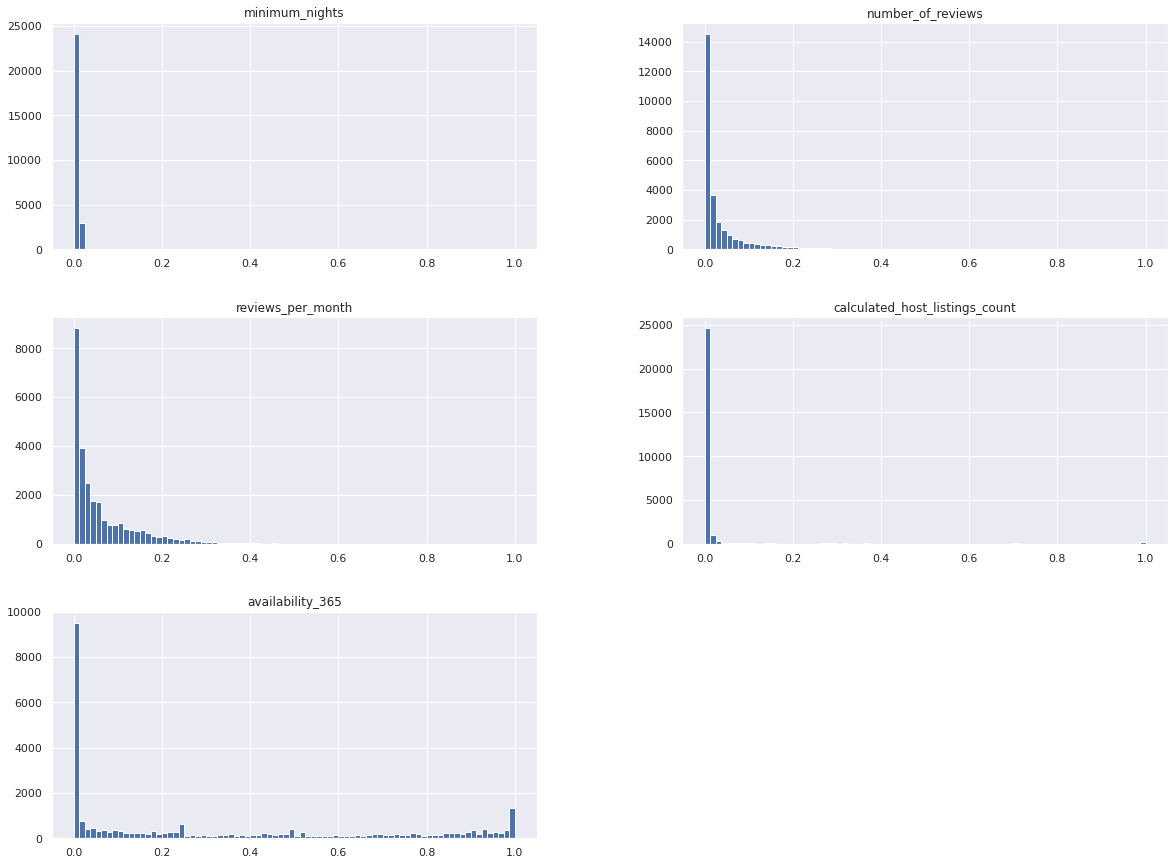

In [ ]:
df_train.loc[:,scalable_features].hist(figsize= (20,15), bins= 80)

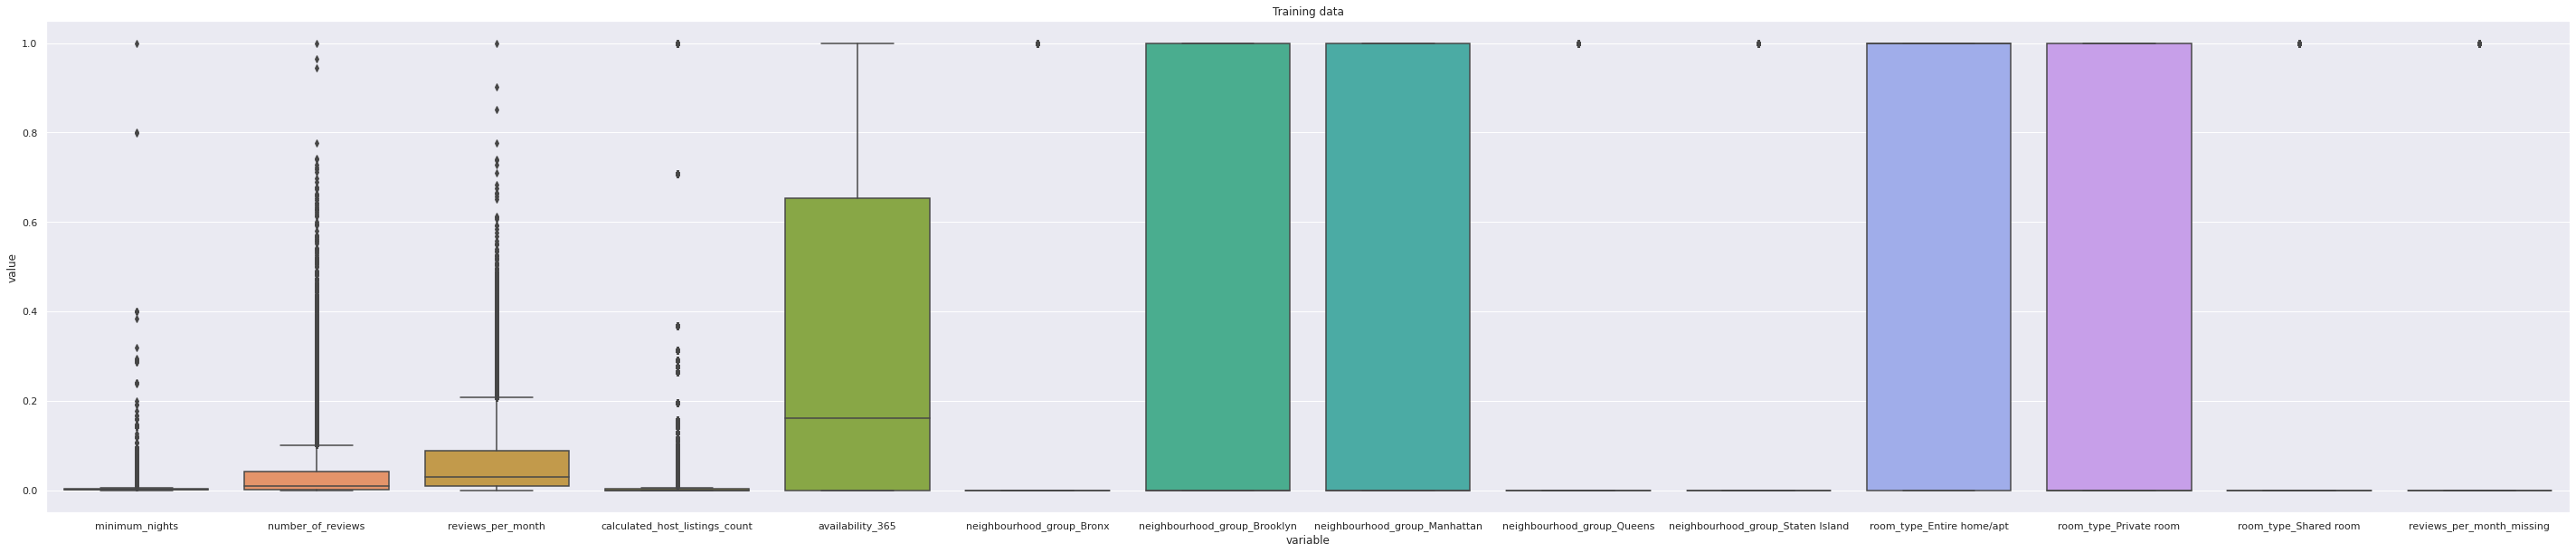

In [ ]:
plt.figure(figsize=(50, 10))
sns.boxplot(x="variable", y="value", data=pd.melt(df_train.iloc[:, :-3])).set_title('Training data')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96b152b048>,
      dtype=object)

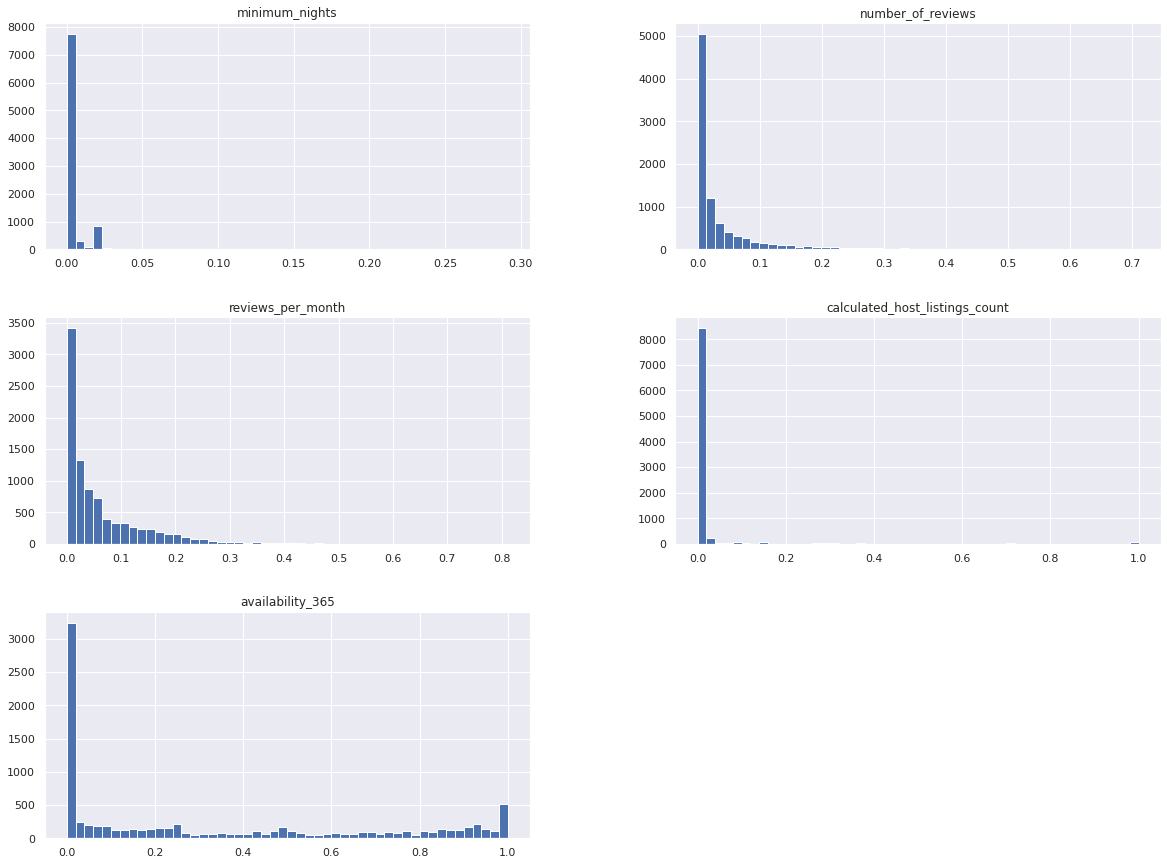

In [ ]:
df_validation.loc[:,scalable_features].hist(figsize= (20,15), bins= 50)

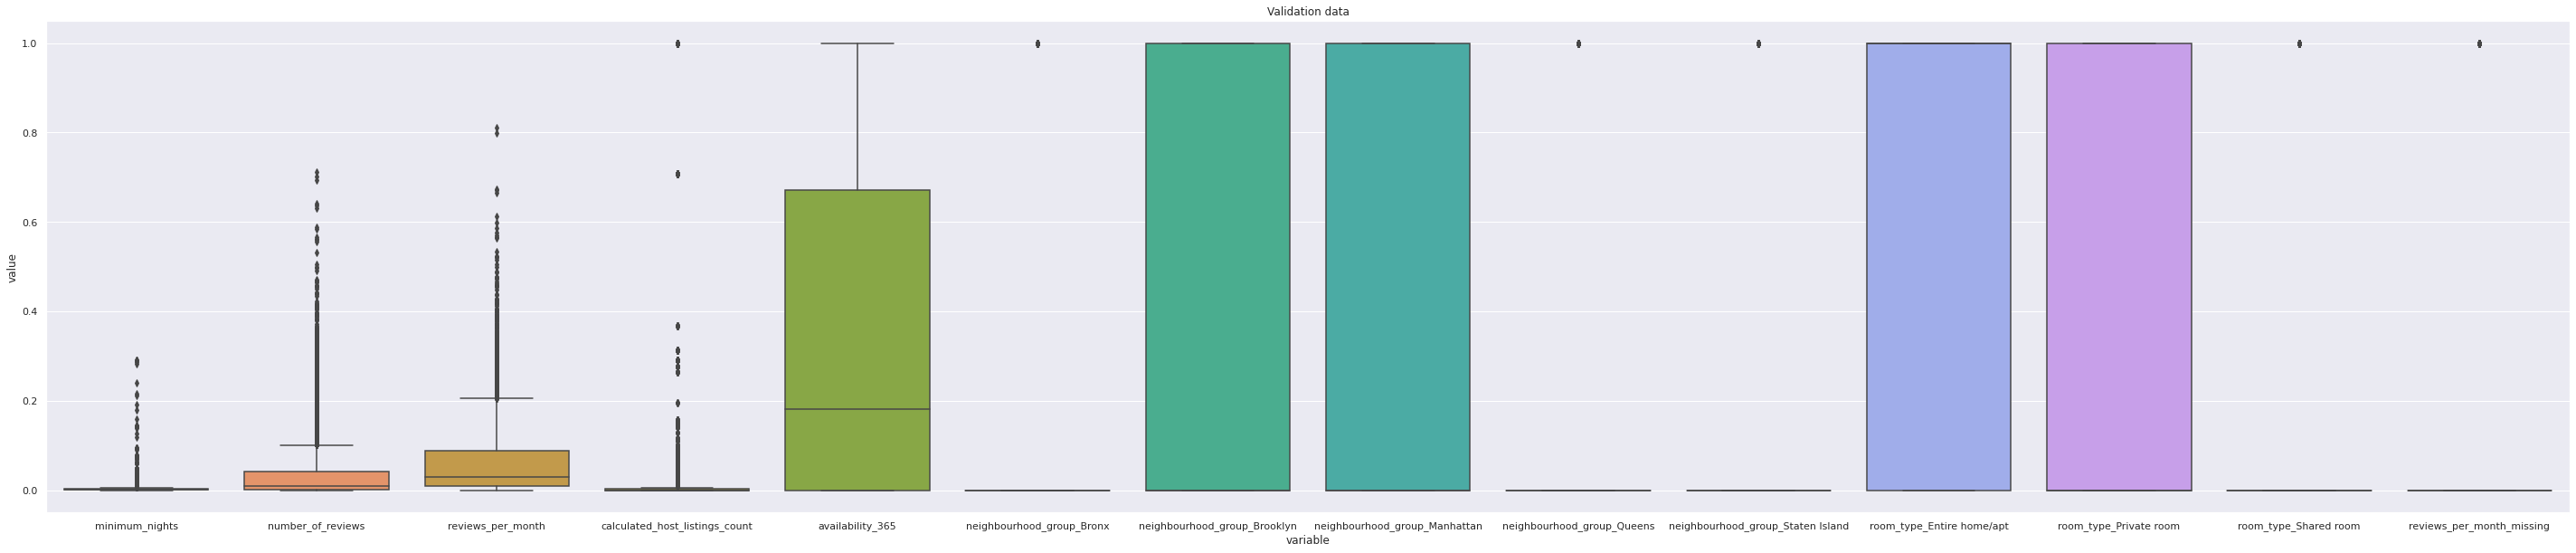

In [ ]:
plt.figure(figsize=(50, 10))
sns.boxplot(x="variable", y="value", data=pd.melt(df_validation.iloc[:, :-3])).set_title('Validation data')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96af42d400>,
      dtype=object)

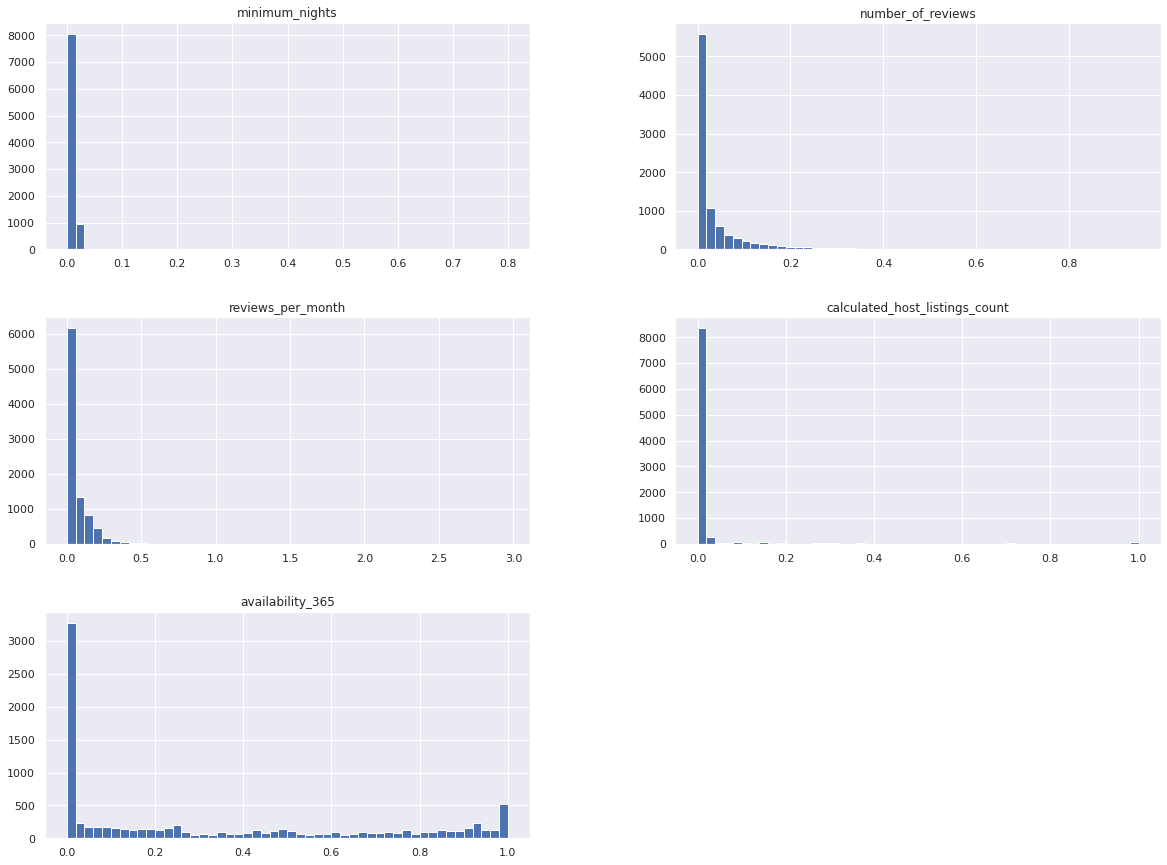

In [ ]:
df_test.loc[:,scalable_features].hist(figsize= (20,15), bins= 50)

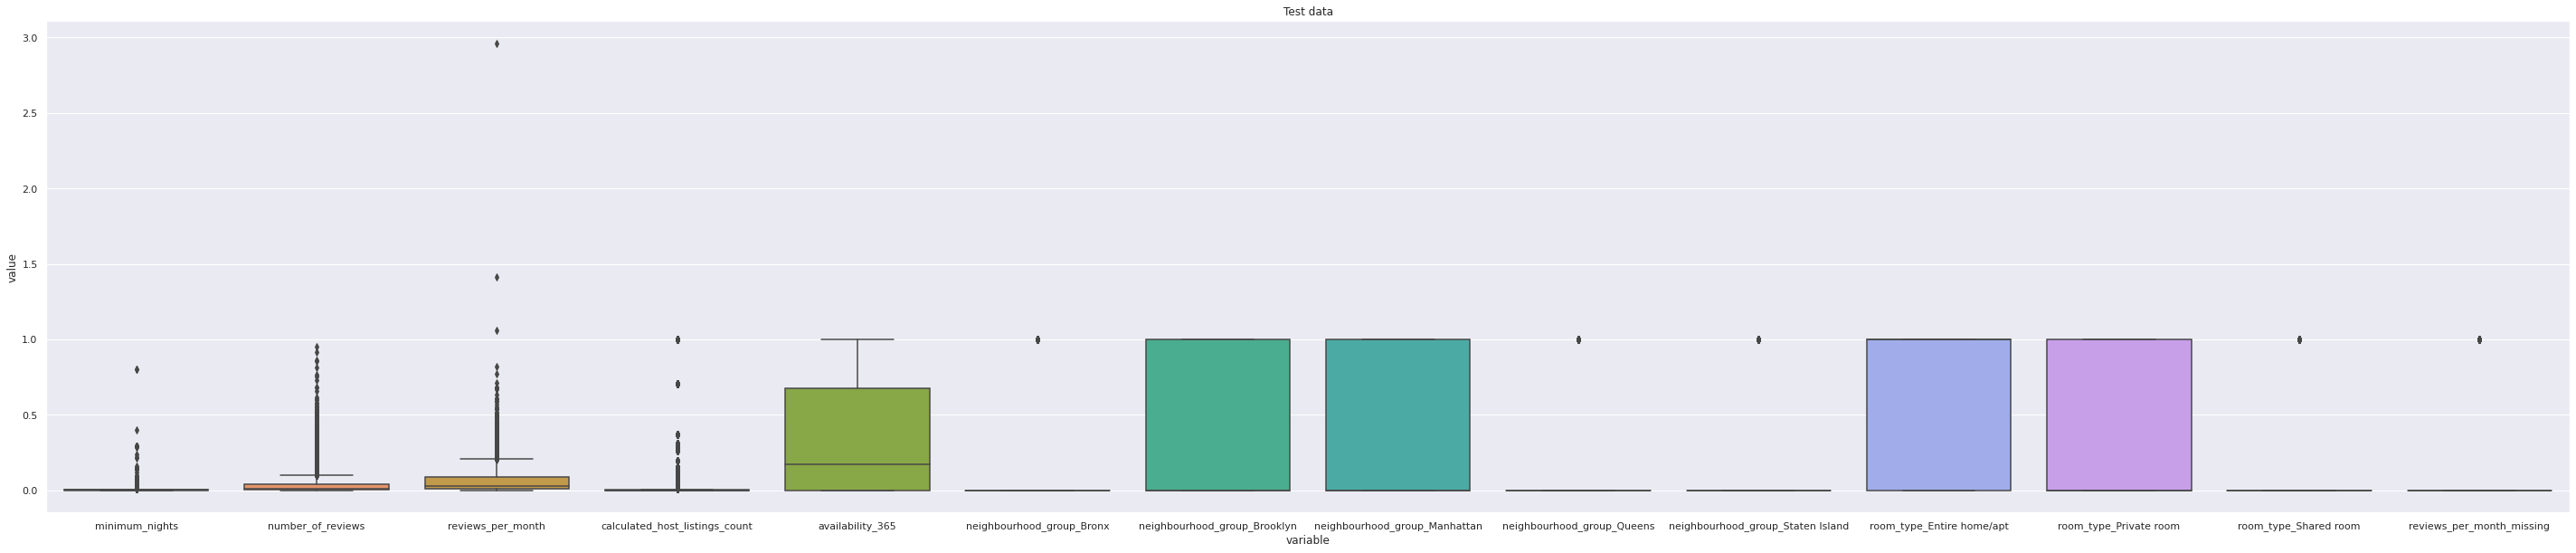

In [ ]:
plt.figure(figsize=(50, 10))
sns.boxplot(x="variable", y="value", data=pd.melt(df_test.iloc[:, :-3])).set_title('Test data')
plt.show()

In [ ]:
display(df_train.describe())

minimum_nights  number_of_reviews  reviews_per_month  \
count    27401.000000       27401.000000       27401.000000   
mean         0.004989           0.039462           0.061536   
std          0.017141           0.072416           0.078533   
min          0.000000           0.000000           0.000000   
25%          0.000801           0.001590           0.008511   
50%          0.001601           0.009539           0.029382   
75%          0.003203           0.041335           0.088146   
max          1.000000           1.000000           1.000000   

       calculated_host_listings_count  availability_365  \
count                    27401.000000      27401.000000   
mean                         0.019445          0.323911   
std                          0.103261          0.361411   
min                          0.000000          0.000000   
25%                          0.000000          0.000000   
50%                          0.000000          0.161644   
75%                          0.003067          0.652055   
max                          1.000000          1.000000   

       neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
count               27401.000000                  27401.000000   
mean                    0.023174                      0.410824   
std                     0.150460                      0.491992   
min                     0.000000                      0.000000   
25%                     0.000000                      0.000000   
50%                     0.000000                      0.000000   
75%                     0.000000                      1.000000   
max                     1.000000                      1.000000   

       neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
count                   27401.000000                27401.000000   
mean                        0.439291                    0.118901   
std                         0.496310                    0.323678   
min                         0.000000                    0.000000   
25%                         0.000000                    0.000000   
50%                         0.000000                    0.000000   
75%                         1.000000                    0.000000   
max                         1.000000                    1.000000   

       neighbourhood_group_Staten Island  room_type_Entire home/apt  \
count                        27401.00000               27401.000000   
mean                             0.00781                   0.526076   
std                              0.08803                   0.499329   
min                              0.00000                   0.000000   
25%                              0.00000                   0.000000   
50%                              0.00000                   1.000000   
75%                              0.00000                   1.000000   
max                              1.00000                   1.000000   

       room_type_Private room  room_type_Shared room  \
count            27401.000000           27401.000000   
mean                 0.447976               0.025948   
std                  0.497295               0.158983   
min                  0.000000               0.000000   
25%                  0.000000               0.000000   
50%                  0.000000               0.000000   
75%                  1.000000               0.000000   
max                  1.000000               1.000000   

       reviews_per_month_missing         price  
count               27401.000000  27401.000000  
mean                    0.164666    154.919565  
std                     0.370885    253.980232  
min                     0.000000     10.000000  
25%                     0.000000     69.000000  
50%                     0.000000    109.000000  
75%                     0.000000    177.000000  
max                     1.000000  10000.000000

In [ ]:
display(df_validation.describe())

minimum_nights  number_of_reviews  reviews_per_month  \
count     9134.000000        9134.000000        9134.000000   
mean         0.004768           0.039093           0.062513   
std          0.013178           0.070293           0.080011   
min          0.000000           0.000000           0.000000   
25%          0.000801           0.001590           0.008612   
50%          0.001601           0.009539           0.029889   
75%          0.003203           0.041335           0.087513   
max          0.291433           0.710652           0.811550   

       calculated_host_listings_count  availability_365  \
count                     9134.000000       9134.000000   
mean                         0.017969          0.331852   
std                          0.096598          0.362374   
min                          0.000000          0.000000   
25%                          0.000000          0.000000   
50%                          0.000000          0.180822   
75%                          0.003067          0.670548   
max                          1.000000          1.000000   

       neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
count                9134.000000                   9134.000000   
mean                    0.023429                      0.409897   
std                     0.151270                      0.491841   
min                     0.000000                      0.000000   
25%                     0.000000                      0.000000   
50%                     0.000000                      0.000000   
75%                     0.000000                      1.000000   
max                     1.000000                      1.000000   

       neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
count                    9134.000000                 9134.000000   
mean                        0.434859                    0.123057   
std                         0.495766                    0.328520   
min                         0.000000                    0.000000   
25%                         0.000000                    0.000000   
50%                         0.000000                    0.000000   
75%                         1.000000                    0.000000   
max                         1.000000                    1.000000   

       neighbourhood_group_Staten Island  room_type_Entire home/apt  \
count                        9134.000000                9134.000000   
mean                            0.008758                   0.520473   
std                             0.093181                   0.499608   
min                             0.000000                   0.000000   
25%                             0.000000                   0.000000   
50%                             0.000000                   1.000000   
75%                             0.000000                   1.000000   
max                             1.000000                   1.000000   

       room_type_Private room  room_type_Shared room  \
count             9134.000000            9134.000000   
mean                 0.456208               0.023319   
std                  0.498106               0.150924   
min                  0.000000               0.000000   
25%                  0.000000               0.000000   
50%                  0.000000               0.000000   
75%                  1.000000               0.000000   
max                  1.000000               1.000000   

       reviews_per_month_missing         price  
count                9134.000000   9134.000000  
mean                    0.160609    150.441209  
std                     0.367190    231.152890  
min                     0.000000     10.000000  
25%                     0.000000     69.000000  
50%                     0.000000    105.000000  
75%                     0.000000    175.000000  
max                     1.000000  10000.000000

In [ ]:
display(df_test.describe())

minimum_nights  number_of_reviews  reviews_per_month  \
count     9134.000000        9134.000000        9134.000000   
mean         0.005308           0.040354           0.062113   
std          0.019413           0.075327           0.087250   
min          0.000000           0.000000           0.000000   
25%          0.000801           0.001590           0.009119   
50%          0.001601           0.009539           0.028875   
75%          0.003203           0.041335           0.087639   
max          0.799039           0.949126           2.963019   

       calculated_host_listings_count  availability_365  \
count                     9134.000000       9134.000000   
mean                         0.021245          0.331348   
std                          0.109422          0.363175   
min                          0.000000          0.000000   
25%                          0.000000          0.000000   
50%                          0.000000          0.172603   
75%                          0.003067          0.673973   
max                          1.000000          1.000000   

       neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
count                9134.000000                   9134.000000   
mean                    0.025509                      0.401139   
std                     0.157674                      0.490156   
min                     0.000000                      0.000000   
25%                     0.000000                      0.000000   
50%                     0.000000                      0.000000   
75%                     0.000000                      1.000000   
max                     1.000000                      1.000000   

       neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
count                    9134.000000                 9134.000000   
mean                        0.441866                    0.122947   
std                         0.496636                    0.328395   
min                         0.000000                    0.000000   
25%                         0.000000                    0.000000   
50%                         0.000000                    0.000000   
75%                         1.000000                    0.000000   
max                         1.000000                    1.000000   

       neighbourhood_group_Staten Island  room_type_Entire home/apt  \
count                        9134.000000                9134.000000   
mean                            0.008540                   0.527151   
std                             0.092019                   0.499290   
min                             0.000000                   0.000000   
25%                             0.000000                   0.000000   
50%                             0.000000                   1.000000   
75%                             0.000000                   1.000000   
max                             1.000000                   1.000000   

       room_type_Private room  room_type_Shared room  \
count             9134.000000            9134.000000   
mean                 0.450077               0.022772   
std                  0.497529               0.149184   
min                  0.000000               0.000000   
25%                  0.000000               0.000000   
50%                  0.000000               0.000000   
75%                  1.000000               0.000000   
max                  1.000000               1.000000   

       reviews_per_month_missing        price  
count                9134.000000  9134.000000  
mean                    0.166630   153.450952  
std                     0.372666   236.064085  
min                     0.000000    10.000000  
25%                     0.000000    69.000000  
50%                     0.000000   109.000000  
75%                     0.000000   179.000000  
max                     1.000000  7703.000000

In [ ]:
df_train = df_train.drop('reviews_per_month_missing', axis='columns')

In [ ]:
df_test = df_test.drop('reviews_per_month_missing', axis='columns')
df_validation = df_validation.drop('reviews_per_month_missing', axis='columns')

# Building QuAMs

In [ ]:
import sklearn
from  sklearn import neighbors
from sklearn import metrics
import plotly.graph_objects as go
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [ ]:
X_train = df_train.drop(df_Labels.columns, axis=1)
y_train_reg = df_train[df_Labels.columns[0]]
y_train_class_general = df_train[df_Labels.columns[1]]
y_train_class_market = df_train[df_Labels.columns[2]]

X_validation = df_validation.drop(df_Labels.columns, axis=1)
y_validation_reg = df_validation[df_Labels.columns[0]]
y_validation_class_general = df_validation[df_Labels.columns[1]]
y_validation_class_market = df_validation[df_Labels.columns[2]]

X_test = df_test.drop(df_Labels.columns, axis=1)
y_test_reg = df_test[df_Labels.columns[0]]
y_test_class_general = df_test[df_Labels.columns[1]]
y_test_class_market = df_test[df_Labels.columns[2]]

## Classification QuAMs

In [ ]:
def TNtable(X_test, y_test, model):
  # calculate TP, FP, TN and FN
  TP_list = []
  FP_list =[]
  TN_list =[]
  FN_list = []

  if model == knn:
    cm = pd.DataFrame(confusion_matrix(y_test, knn.predict(X_test)))

  else:
    cm = pd.DataFrame(confusion_matrix(y_test, dt.predict(X_test)))

  for i in range(0,4):
    TP = cm.iloc[i,i]
    FP = cm.iloc[i, :].sum() - TP
    FN = cm.iloc[:, i].sum() - TP
    TN = np.sum(np.array(cm)) - FP - FN -TP
    TP_list.append(TP)
    FN_list.append(FN)
    TN_list.append(TN)
    FP_list.append(FP)

  TN_table =  pd.DataFrame({'True Positive' : TP_list, "True Negative" : TN_list, "False Positive (Type 1 error)" : FP_list, "False Negative (Type 2 error)": FN_list}, index= ['cheap', 'expensive', 'medium',  'very expensive'] )

  return TN_table

### KNN

In [ ]:
def KNNaccuracy(X_train, y_train, X_test, y_test, weights, k_bounds):
  best_score = -np.infty
  best_k = np.nan
  accuracy = []
  precision = []
  recall = []
  train_accs = []
  f1 = []
  kList = []
  for k in range(k_bounds[0], k_bounds[1]+1, 1):
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, weights = weights)
    knn.fit(X_train, y_train)
    yhat_test = knn.predict(X_test)
    yhat_train = knn.predict(X_train)
    train_acc = round(accuracy_score(y_train, yhat_train), 4)
    accu_score = round(accuracy_score(y_test, yhat_test), 4)
    prec_score = round(precision_score(y_test, yhat_test, average='weighted'), 4)
    rec_score = round(recall_score(y_test, yhat_test, average='weighted'), 4)
    F1_score = round(f1_score(y_test, yhat_test, average='weighted'), 4)
    train_accs.append(train_acc)
    accuracy.append(accu_score)
    precision.append(prec_score)
    recall.append(rec_score)
    f1.append(F1_score)
    kList.append(k)
    scores = [train_acc, accu_score, prec_score, rec_score, F1_score]
    if accu_score > best_score:
      best_score = accu_score
      best_k = k

  scores_table = pd.DataFrame({'k': kList,'train accuracy' : train_accs, 'accuracy' : accuracy, 'precision': precision, 'recall': recall, 'f1': f1 })

  print('Base on accuracy metric, our best k = ', best_k, ' where best accuracy is = ', best_score)

  return scores_table


#### Classification in general

In [ ]:
scores_table=KNNaccuracy(X_train, y_train_class_general, X_validation, y_validation_class_general, 'uniform', [1,40])

Base on accuracy metric, our best k =  32  where best accuracy is =  0.5958


In [ ]:
scores_table

k  train accuracy  accuracy  precision  recall      f1
0    1          0.9315    0.5070     0.5106  0.5070  0.5086
1    2          0.7329    0.4949     0.5197  0.4949  0.4778
2    3          0.7251    0.5363     0.5315  0.5363  0.5314
3    4          0.6885    0.5366     0.5374  0.5366  0.5303
4    5          0.6823    0.5534     0.5456  0.5534  0.5460
5    6          0.6649    0.5550     0.5494  0.5550  0.5482
6    7          0.6633    0.5632     0.5533  0.5632  0.5555
7    8          0.6561    0.5591     0.5491  0.5591  0.5499
8    9          0.6552    0.5661     0.5554  0.5661  0.5568
9   10          0.6485    0.5680     0.5560  0.5680  0.5580
10  11          0.6473    0.5737     0.5616  0.5737  0.5623
11  12          0.6444    0.5795     0.5676  0.5795  0.5682
12  13          0.6415    0.5801     0.5682  0.5801  0.5687
13  14          0.6409    0.5800     0.5673  0.5800  0.5679
14  15          0.6367    0.5801     0.5674  0.5801  0.5678
15  16          0.6380    0.5789     0.5648  0.5789  0.5658
16  17          0.6341    0.5809     0.5675  0.5809  0.5676
17  18          0.6332    0.5813     0.5671  0.5813  0.5676
18  19          0.6321    0.5795     0.5656  0.5795  0.5651
19  20          0.6299    0.5828     0.5682  0.5828  0.5681
20  21          0.6270    0.5844     0.5698  0.5844  0.5695
21  22          0.6257    0.5843     0.5701  0.5843  0.5697
22  23          0.6244    0.5844     0.5711  0.5844  0.5700
23  24          0.6248    0.5878     0.5750  0.5878  0.5724
24  25          0.6240    0.5863     0.5732  0.5863  0.5712
25  26          0.6217    0.5890     0.5759  0.5890  0.5740
26  27          0.6224    0.5902     0.5779  0.5902  0.5752
27  28          0.6221    0.5916     0.5789  0.5916  0.5765
28  29          0.6206    0.5916     0.5787  0.5916  0.5763
29  30          0.6200    0.5940     0.5824  0.5940  0.5785
30  31          0.6202    0.5944     0.5813  0.5944  0.5784
31  32          0.6191    0.5958     0.5829  0.5958  0.5799
32  33          0.6179    0.5936     0.5814  0.5936  0.5776
33  34          0.6177    0.5946     0.5825  0.5946  0.5784
34  35          0.6169    0.5946     0.5811  0.5946  0.5778
35  36          0.6167    0.5931     0.5812  0.5931  0.5767
36  37          0.6177    0.5919     0.5789  0.5919  0.5747
37  38          0.6166    0.5891     0.5761  0.5891  0.5717
38  39          0.6153    0.5900     0.5744  0.5900  0.5730
39  40          0.6158    0.5913     0.5780  0.5913  0.5737

In [ ]:
fig = px.line(scores_table.melt(id_vars='k', value_vars=['train accuracy', 'accuracy']), x='k' , y='value' , color='variable')
fig.show()

In [ ]:
fig = px.line(scores_table.melt(id_vars='k', value_vars=['accuracy', 'precision', 'recall', 'f1']), x='k' , y='value' , color='variable')
fig.show()

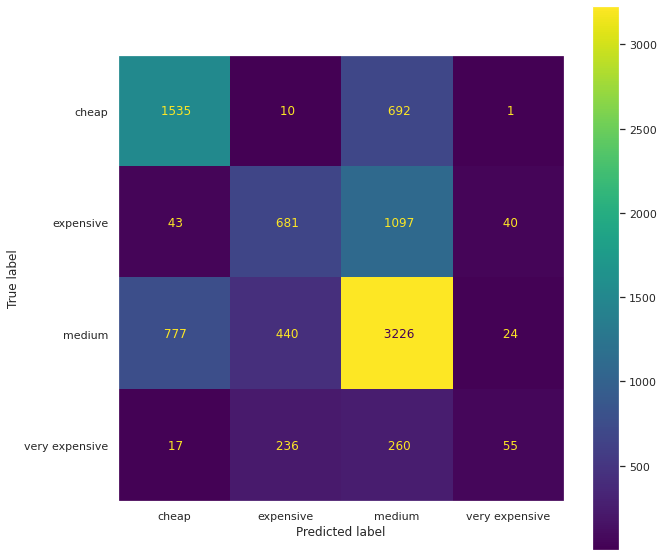

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 32)
knn.fit(X_train, y_train_class_general)
fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(None)
plot_confusion_matrix(knn, X_test, y_test_class_general,values_format = ' ', ax = ax)

In [ ]:
TNtable(X_test, y_test_class_general, knn)

True Positive  True Negative  False Positive (Type 1 error)  \
cheap                    1535           6059                            703   
expensive                 681           6587                           1180   
medium                   3226           2618                           1241   
very expensive             55           8501                            513   

                False Negative (Type 2 error)  
cheap                                     837  
expensive                                 686  
medium                                   2049  
very expensive                             65

#### Classification by market

In [ ]:
scores_table_markt = KNNaccuracy(X_train, y_train_class_market, X_validation, y_validation_class_general, 'uniform', [1,20])

Base on accuracy metric, our best k =  20  where best accuracy is =  0.4467


In [ ]:
scores_table_markt

k  train accuracy  accuracy  precision  recall      f1
0    1          0.9176    0.3707     0.3737  0.3707  0.3720
1    2          0.6664    0.3273     0.3698  0.3273  0.3286
2    3          0.6396    0.3737     0.3742  0.3737  0.3706
3    4          0.6137    0.3756     0.3703  0.3756  0.3717
4    5          0.5924    0.3811     0.3706  0.3811  0.3738
5    6          0.5807    0.3936     0.3741  0.3936  0.3807
6    7          0.5704    0.4052     0.3790  0.4052  0.3877
7    8          0.5633    0.4057     0.3757  0.4057  0.3852
8    9          0.5570    0.4141     0.3781  0.4141  0.3886
9   10          0.5506    0.4207     0.3802  0.4207  0.3903
10  11          0.5464    0.4265     0.3832  0.4265  0.3936
11  12          0.5434    0.4294     0.3835  0.4294  0.3930
12  13          0.5413    0.4311     0.3830  0.4311  0.3922
13  14          0.5382    0.4384     0.3879  0.4384  0.3964
14  15          0.5361    0.4376     0.3833  0.4376  0.3913
15  16          0.5330    0.4402     0.3826  0.4402  0.3912
16  17          0.5300    0.4412     0.3809  0.4412  0.3893
17  18          0.5276    0.4439     0.3829  0.4439  0.3905
18  19          0.5257    0.4427     0.3802  0.4427  0.3883
19  20          0.5240    0.4467     0.3824  0.4467  0.3885

In [ ]:
fig = px.line(scores_table_markt.melt(id_vars='k', value_vars=['train accuracy', 'accuracy']), x='k' , y='value' , color='variable')
fig.show()

In [ ]:
fig = px.line(scores_table_markt.melt(id_vars='k', value_vars=['accuracy', 'precision', 'recall', 'f1']), x='k' , y='value' , color='variable')
fig.show()

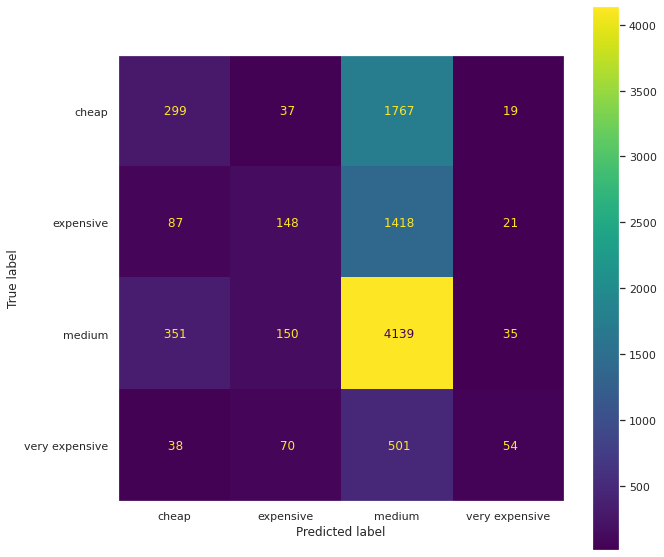

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 40)
knn.fit(X_train, y_train_class_market)
fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(None)
plot_confusion_matrix(knn, X_test, y_test_class_market,values_format = ' ', ax = ax)

In [ ]:
TNtable(X_test, y_test_class_market, knn)

True Positive  True Negative  False Positive (Type 1 error)  \
cheap                     299           6536                           1823   
expensive                 148           7203                           1526   
medium                   4139            773                            536   
very expensive             54           8396                            609   

                False Negative (Type 2 error)  
cheap                                     476  
expensive                                 257  
medium                                   3686  
very expensive                             75

### Decision Trees

#### Classification in general

In [ ]:
def DTaccuracy(X_train, y_train, X_test, y_test, depth_bounds):
  best_score = -np.infty
  best_depth = np.nan
  accuracy = []
  precision = []
  recall = []
  train_accs = []
  f1 = []
  depthList = []
  for depth in range(depth_bounds[0], depth_bounds[1]+1, 1):
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    yhat_test = dt.predict(X_test)
    yhat_train = dt.predict(X_train)
    train_acc = round(accuracy_score(y_train, yhat_train), 4)
    accu_score = round(accuracy_score(y_test, yhat_test), 4)
    prec_score = round(precision_score(y_test, yhat_test, average='weighted'), 4)
    rec_score = round(recall_score(y_test, yhat_test, average='weighted'), 4)
    F1_score = round(f1_score(y_test, yhat_test, average='weighted'), 4)
    train_accs.append(train_acc)
    accuracy.append(accu_score)
    precision.append(prec_score)
    recall.append(rec_score)
    f1.append(F1_score)
    depthList.append(depth)
    scores = [train_acc, accu_score, prec_score, rec_score, F1_score]
    if accu_score > best_score:
      best_score = accu_score
      best_depth = depth

  scores_table = pd.DataFrame({'max depth': depthList,'train accuracy' : train_accs, 'accuracy' : accuracy, 'precision': precision, 'recall': recall, 'f1': f1 })

  print('Base on accuracy metric, our best maximum depth = ', best_depth, ' where best accuracy is = ', best_score)

  return scores_table


In [ ]:
dt_scores_table_general = DTaccuracy(X_train, y_train_class_general, X_validation, y_validation_class_general, [1,20])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Base on accuracy metric, our best maximum depth =  7  where best accuracy is =  0.5993


In [ ]:
dt_scores_table_general

max depth  train accuracy  accuracy  precision  recall      f1
0           1          0.5042    0.5018     0.3768  0.5018  0.4209
1           2          0.5730    0.5767     0.5537  0.5767  0.5593
2           3          0.5890    0.5834     0.5406  0.5834  0.5557
3           4          0.5909    0.5861     0.5432  0.5861  0.5606
4           5          0.5999    0.5916     0.5579  0.5916  0.5612
5           6          0.6104    0.5943     0.6094  0.5943  0.5630
6           7          0.6180    0.5993     0.5862  0.5993  0.5701
7           8          0.6279    0.5955     0.5755  0.5955  0.5701
8           9          0.6385    0.5982     0.5819  0.5982  0.5761
9          10          0.6503    0.5970     0.5782  0.5970  0.5750
10         11          0.6646    0.5902     0.5730  0.5902  0.5725
11         12          0.6837    0.5867     0.5670  0.5867  0.5687
12         13          0.7030    0.5852     0.5702  0.5852  0.5734
13         14          0.7243    0.5750     0.5597  0.5750  0.5633
14         15          0.7474    0.5623     0.5484  0.5623  0.5524
15         16          0.7690    0.5608     0.5490  0.5608  0.5526
16         17          0.7916    0.5526     0.5426  0.5526  0.5460
17         18          0.8123    0.5483     0.5387  0.5483  0.5421
18         19          0.8326    0.5397     0.5328  0.5397  0.5357
19         20          0.8502    0.5324     0.5260  0.5324  0.5286

In [ ]:
fig = px.line(dt_scores_table_general.melt(id_vars='max depth', value_vars=['train accuracy', 'accuracy']), x='max depth' , y='value' , color='variable')
fig.show()

In [ ]:
fig = px.line(dt_scores_table_general.melt(id_vars='max depth', value_vars=['accuracy', 'precision', 'recall', 'f1']), x='max depth' , y='value' , color='variable')
fig.show()

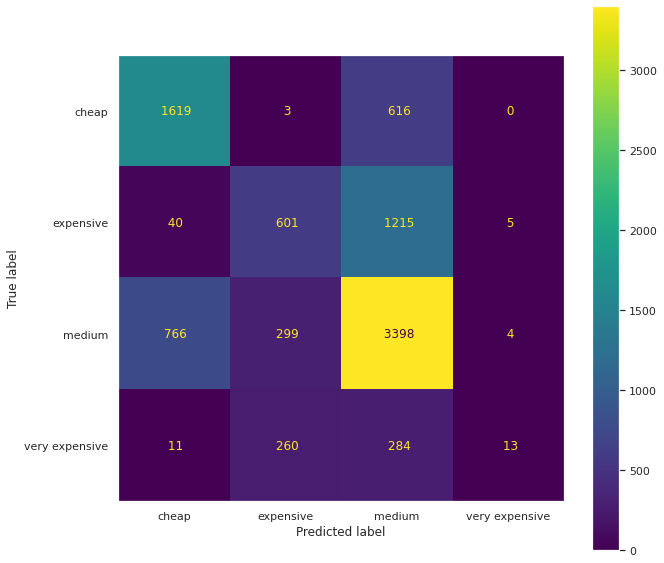

In [ ]:
dt = DecisionTreeClassifier(max_depth= 7)
dt.fit(X_train, y_train_class_general)
fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(None)
plot_confusion_matrix(dt, X_test, y_test_class_general,values_format = ' ', ax = ax)

In [ ]:
TNtable(X_test, y_test_class_general, dt)

True Positive  True Negative  False Positive (Type 1 error)  \
cheap                    1619           6079                            619   
expensive                 601           6711                           1260   
medium                   3398           2552                           1069   
very expensive             13           8557                            555   

                False Negative (Type 2 error)  
cheap                                     817  
expensive                                 562  
medium                                   2115  
very expensive                              9

#### Classification by market

In [ ]:
dt_scores_table_market = DTaccuracy(X_train, y_train_class_market, X_validation, y_validation_class_market, [1,20])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Base on accuracy metric, our best maximum depth =  4  where best accuracy is =  0.5074


In [ ]:
display(dt_scores_table_market)

max depth  train accuracy  accuracy  precision  recall      f1
0           1          0.4894    0.4997     0.2497  0.4997  0.3330
1           2          0.4909    0.5008     0.3508  0.5008  0.3401
2           3          0.4955    0.5000     0.5005  0.5000  0.3826
3           4          0.4972    0.5074     0.5833  0.5074  0.3545
4           5          0.4998    0.5030     0.4905  0.5030  0.3973
5           6          0.5046    0.5062     0.4884  0.5062  0.3927
6           7          0.5084    0.5049     0.4720  0.5049  0.4130
7           8          0.5172    0.5048     0.4777  0.5048  0.4062
8           9          0.5274    0.5063     0.4718  0.5063  0.4276
9          10          0.5401    0.4977     0.4533  0.4977  0.4244
10         11          0.5546    0.4954     0.4527  0.4954  0.4273
11         12          0.5748    0.4891     0.4398  0.4891  0.4251
12         13          0.5983    0.4771     0.4303  0.4771  0.4267
13         14          0.6247    0.4736     0.4275  0.4736  0.4283
14         15          0.6530    0.4641     0.4222  0.4641  0.4268
15         16          0.6830    0.4553     0.4192  0.4553  0.4260
16         17          0.7131    0.4332     0.4045  0.4332  0.4134
17         18          0.7440    0.4305     0.4048  0.4305  0.4134
18         19          0.7709    0.4223     0.4012  0.4223  0.4090
19         20          0.7991    0.4205     0.4022  0.4205  0.4094

In [ ]:
fig = px.line(dt_scores_table_market.melt(id_vars='max depth', value_vars=['train accuracy', 'accuracy']), x='max depth' , y='value' , color='variable')
fig.show()

In [ ]:
fig = px.line(dt_scores_table_market.melt(id_vars='max depth', value_vars=['accuracy', 'precision', 'recall', 'f1']), x='max depth' , y='value' , color='variable')
fig.show()

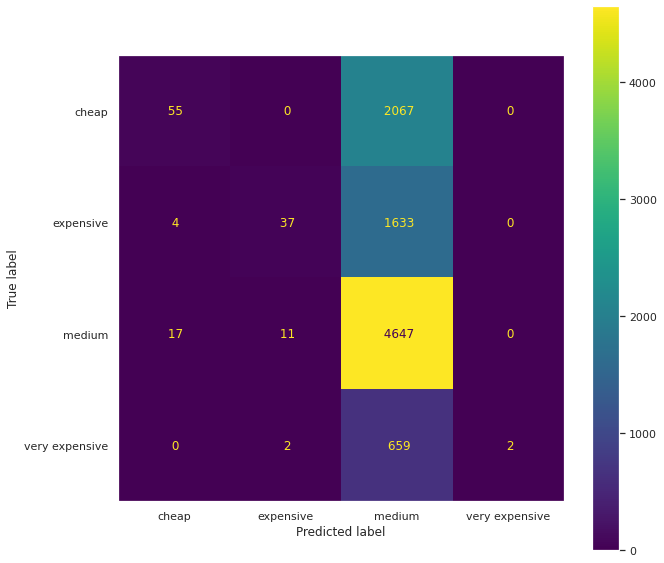

In [ ]:
dt = DecisionTreeClassifier(max_depth= 4)
dt.fit(X_train, y_train_class_market)
fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(None)
plot_confusion_matrix(dt, X_test, y_test_class_market, values_format = ' ', ax = ax)

In [ ]:
TNtable(X_test, y_test_class_market, dt)

True Positive  True Negative  False Positive (Type 1 error)  \
cheap                      55           6991                           2067   
expensive                  37           7447                           1637   
medium                   4647            100                             28   
very expensive              2           8471                            661   

                False Negative (Type 2 error)  
cheap                                      21  
expensive                                  13  
medium                                   4359  
very expensive                              0

## Regression QuAMs

### Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [ ]:
def linearReg(X_train, y_train, X_valid, y_valid, X_test, y_test):
  lr = LinearRegression()
  lr.fit(X_train, y_train)

  yhat_train_mse = lr.predict(X_train)
  yhat_test_mse = lr.predict(X_test)

  yhat_train_mae = lr.predict(X_train)
  yhat_test_mae = lr.predict(X_test)

  yhat_train_r2 = lr.predict(X_train)
  yhat_test_r2 = lr.predict(X_test)

  score_train_mse = round(metrics.mean_squared_error(y_train, yhat_train_mse), 4)
  score_test_mse = round(metrics.mean_squared_error(y_test, yhat_test_mse), 4)

  score_train_mae = round(metrics.mean_absolute_error(y_train, yhat_train_mae), 4)
  score_test_mae = round(metrics.mean_absolute_error(y_test, yhat_test_mae), 4)

  score_train_r2 = round(metrics.r2_score(y_train, yhat_train_r2), 4)
  score_test_r2 = round(metrics.r2_score(y_test, yhat_test_r2), 4)

  scoreList = [score_train_mse, score_test_mse, score_train_mae, score_test_mae, score_train_r2, score_test_r2]

  return scoreList


In [ ]:
score_linear = linearReg(X_train, y_train_reg, X_validation, y_validation_reg, X_test, y_test_reg)

In [ ]:
print("MSE Train:", score_linear[0])
print("MSE Test:", score_linear[1])
print("MAE Train:", score_linear[2])
print("MAE Test:", score_linear[3])
print("R2 Train:", score_linear[4])
print("R2 Test:", score_linear[5])

MSE Train: 58903.0359
MSE Test: 50694.8259
MAE Train: 77.6577
MAE Test: 75.7711
R2 Train: 0.0868
R2 Test: 0.0902


### KNN regression

In [ ]:
from  sklearn.neighbors import KNeighborsRegressor

In [ ]:
def KNR(X_train, y_train, X_valid, y_valid, X_test, y_test, k_bounds):
  best_mse = np.infty
  best_mae = np.infty
  best_r2 = -np.infty
  best_alpha_mse = np.nan
  best_alpha_mae = np.nan
  best_alpha_r2 = np.nan
  mse = []
  mae = []
  r2 = []
  r2_train_list = []
  mae_train_list = []
  kList = []
  counter = 1
  for k in np.arange(k_bounds[0], k_bounds[1]+1, 2):
    print(counter, "Number of k:", k)
    counter += 1
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(X_train, y_train)
    yhat_valid = knr.predict(X_valid)
    yhat_train = knr.predict(X_train)
    mse_score = round(metrics.mean_squared_error(y_valid, yhat_valid), 4)
    mae_score = round(metrics.mean_absolute_error(y_valid, yhat_valid), 4)
    r2_score = round(metrics.r2_score(y_valid, yhat_valid), 4)
    r2_train = round(metrics.r2_score(y_train, yhat_train), 4)
    mae_train = round(metrics.mean_absolute_error(y_train, yhat_train), 4)
    mse.append(mse_score)
    mae.append(mae_score)
    r2.append(r2_score)
    r2_train_list.append(r2_train)
    mae_train_list.append(mae_train)
    kList.append(k)

    if mse_score < best_mse:
      best_mse = mse_score
      best_k_mse = k

    if mae_score < best_mae:
      best_mae = mae_score
      best_k_mae = k

    if r2_score > best_r2:
      best_r2 = r2_score
      best_k_r2 = k

  print("For loop Done!")
  best_regressor_mse = KNeighborsRegressor(n_neighbors=best_k_mse)
  best_regressor_mse.fit(X_train, y_train)
  yhat_train_mse = best_regressor_mse.predict(X_train)
  yhat_test_mse = best_regressor_mse.predict(X_test)
  score_train_mse = round(metrics.mean_squared_error(y_train, yhat_train_mse), 4)
  score_test_mse = round(metrics.mean_squared_error(y_test, yhat_test_mse), 4)

  best_regressor_mae = KNeighborsRegressor(n_neighbors=best_k_mae)
  best_regressor_mae.fit(X_train, y_train)
  yhat_train_mae = best_regressor_mae.predict(X_train)
  yhat_test_mae = best_regressor_mae.predict(X_test)
  score_train_mae = round(metrics.mean_absolute_error(y_train, yhat_train_mae), 4)
  score_test_mae = round(metrics.mean_absolute_error(y_test, yhat_test_mae), 4)

  best_regressor_r2 = KNeighborsRegressor(n_neighbors=best_k_r2)
  best_regressor_r2.fit(X_train, y_train)
  yhat_train_r2 = best_regressor_r2.predict(X_train)
  yhat_test_r2 = best_regressor_r2.predict(X_test)
  score_train_r2 = round(metrics.r2_score(y_train, yhat_train_r2), 4)
  score_test_r2 = round(metrics.r2_score(y_test, yhat_test_r2), 4)

  scores_table = pd.DataFrame({'k': kList, 'Mean Squared Error' : mse, 'Mean Absolute Error Validation': mae,  'Mean Absolute Error Train': mae_train_list, 'R2 Validation': r2 , 'R2 Train': r2_train_list})

  print('MSE : ', 'best k = ', best_k_mse ,  ' where train score is = ', score_train_mse, ' and test score is :', score_test_mse)

  print('MAE : ', 'best k = ', best_k_mae , ' where train score is = ', score_train_mae, ' and test score is :', score_test_mae)

  print('R2    : ', 'best k = ', best_k_r2 , ' where train score is = ', score_train_r2, ' and test score is :', score_test_r2)

  return [score_train_mse, score_test_mse, score_train_mae, score_test_mae,  score_train_r2,  score_test_r2, scores_table]

In [ ]:
score_knr =  KNR(X_train, y_train_reg, X_validation, y_validation_reg, X_test, y_test_reg, [1, 80])

1 Number of k: 1
2 Number of k: 3
3 Number of k: 5
4 Number of k: 7
5 Number of k: 9
6 Number of k: 11
7 Number of k: 13
8 Number of k: 15
9 Number of k: 17
10 Number of k: 19
11 Number of k: 21
12 Number of k: 23
13 Number of k: 25
14 Number of k: 27
15 Number of k: 29
16 Number of k: 31
17 Number of k: 33
18 Number of k: 35
19 Number of k: 37
20 Number of k: 39
21 Number of k: 41
22 Number of k: 43
23 Number of k: 45
24 Number of k: 47
25 Number of k: 49
26 Number of k: 51
27 Number of k: 53
28 Number of k: 55
29 Number of k: 57
30 Number of k: 59
31 Number of k: 61
32 Number of k: 63
33 Number of k: 65
34 Number of k: 67
35 Number of k: 69
36 Number of k: 71
37 Number of k: 73
38 Number of k: 75
39 Number of k: 77
40 Number of k: 79
For loop Done!
MSE :  best k =  71  where train score is =  55749.1545  and test score is : 48657.5381
MAE :  best k =  59  where train score is =  72.7674  and test score is : 70.9118
R2    :  best k =  71  where train score is =  0.1357  and test score

In [ ]:
knr_table = score_knr[6]

In [ ]:
display(knr_table)

k  Mean Squared Error  Mean Absolute Error Validation  \
0    1         105267.6520                         93.0925   
1    3          65192.9727                         80.9337   
2    5          60311.0210                         78.4385   
3    7          55536.5228                         75.7659   
4    9          53680.3027                         74.3982   
5   11          52460.6678                         73.8503   
6   13          51362.1867                         73.2158   
7   15          50895.5282                         72.7414   
8   17          50430.6069                         72.1836   
9   19          49978.8879                         72.2205   
10  21          49734.3369                         71.9516   
11  23          49412.3269                         71.5617   
12  25          49142.5899                         71.4175   
13  27          48979.9007                         71.2650   
14  29          48664.6691                         71.1029   
15  31          48491.1412                         70.8383   
16  33          48483.2830                         70.8727   
17  35          48523.2725                         71.0115   
18  37          48247.9197                         71.1106   
19  39          48035.0439                         71.0273   
20  41          48105.3373                         71.1271   
21  43          47950.1782                         71.0051   
22  45          47968.6287                         71.0139   
23  47          47929.6046                         70.8852   
24  49          47911.2659                         70.8407   
25  51          47909.3726                         70.7896   
26  53          47784.3451                         70.7975   
27  55          47785.4449                         70.7299   
28  57          47834.9892                         70.8311   
29  59          47829.8246                         70.7094   
30  61          47713.3464                         70.8792   
31  63          47692.1849                         70.7852   
32  65          47673.5322                         70.9388   
33  67          47623.3711                         70.9342   
34  69          47526.7645                         71.0029   
35  71          47523.8501                         70.9697   
36  73          47527.4784                         70.9312   
37  75          47567.6386                         70.9584   
38  77          47570.0572                         70.9441   
39  79          47583.7775                         70.9128   

    Mean Absolute Error Train  R2 Validation  R2 Train  
0                     14.8604        -0.9704    0.6235  
1                     60.0165        -0.2203    0.3935  
2                     66.1893        -0.1289    0.3078  
3                     67.9845        -0.0395    0.2645  
4                     68.7387        -0.0048    0.2411  
5                     69.5061         0.0181    0.2237  
6                     70.0914         0.0386    0.2076  
7                     70.7137         0.0474    0.1976  
8                     70.8742         0.0561    0.1916  
9                     71.2393         0.0645    0.1836  
10                    71.3799         0.0691    0.1780  
11                    71.3025         0.0751    0.1745  
12                    71.4343         0.0802    0.1685  
13                    71.5682         0.0832    0.1647  
14                    71.5752         0.0891    0.1619  
15                    71.7040         0.0924    0.1604  
16                    71.8589         0.0925    0.1577  
17                    72.0710         0.0918    0.1536  
18                    72.1919         0.0969    0.1533  
19                    72.2791         0.1009    0.1509  
20                    72.4240         0.0996    0.1489  
21                    72.4452         0.1025    0.1469  
22                    72.5162         0.1021    0.1452  
23                    72.6057         0.1029    0.1427  
24                    72.6780        

In [ ]:
fig = px.line(knr_table.melt(id_vars='k', value_vars=['R2 Train', 'R2 Validation']), x='k' , y='value' , color='variable')
fig.show()

In [ ]:
fig = px.line(knr_table.melt(id_vars='k', value_vars=['Mean Absolute Error Train', 'Mean Absolute Error Validation']), x='k' , y='value' , color='variable')
fig.show()

In [ ]:
score_knr = score_knr[:6]

In [ ]:
print("MSE Train:", score_knr[0])
print("MSE Test:", score_knr[1])
print("MAE Train:", score_knr[2])
print("MAE Test:", score_knr[3])
print("R2 Train:", score_knr[4])
print("R2 Test:", score_knr[5])

MSE Train: 55749.1545
MSE Test: 48657.5381
MAE Train: 72.7674
MAE Test: 70.9118
R2 Train: 0.1357
R2 Test: 0.1268


### Ridge regression

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
def ridge(X_train, y_train, X_valid, y_valid, X_test, y_test, alpha_bounds):
  best_mse = np.infty
  best_mae = np.infty
  best_r2 = -np.infty
  best_alpha_mse = np.nan
  best_alpha_mae = np.nan
  best_alpha_r2 = np.nan
  mse = []
  mae = []
  r2 = []
  r2_train_list = []
  mae_train_list = []
  alphaList = []
  counter = 0
  for log_regularization_coefficient in np.linspace(alpha_bounds[0], alpha_bounds[1], 50):
    alpha = np.exp(log_regularization_coefficient)
    counter += 1
    print(counter, "alpha:", alpha)
    R = Ridge(alpha = alpha)
    R.fit(X_train, y_train)
    yhat_valid = R.predict(X_valid)
    yhat_train = R.predict(X_train)
    mse_score = round(metrics.mean_squared_error(y_valid, yhat_valid), 4)
    mae_score = round(metrics.mean_absolute_error(y_valid, yhat_valid), 4)
    r2_score = round(metrics.r2_score(y_valid, yhat_valid), 4)
    r2_train = round(metrics.r2_score(y_train, yhat_train), 4)
    mae_train = round(metrics.mean_absolute_error(y_train, yhat_train), 4)
    mse.append(mse_score)
    mae.append(mae_score)
    r2.append(r2_score)
    r2_train_list.append(r2_train)
    mae_train_list.append(mae_train)
    alphaList.append(alpha)

    if mse_score < best_mse:
      best_mse = mse_score
      best_alpha_mse = alpha

    if mae_score < best_mae:
      best_mae = mae_score
      best_alpha_mae = alpha

    if r2_score > best_r2:
      best_r2 = r2_score
      best_alpha_r2 = alpha


  print("For loop Done!")
  best_regressor_mse = Ridge(alpha = best_alpha_mse)
  best_regressor_mse.fit(X_train, y_train)
  yhat_train_mse = best_regressor_mse.predict(X_train)
  yhat_test_mse = best_regressor_mse.predict(X_test)
  score_train_mse = round(metrics.mean_squared_error(y_train, yhat_train_mse), 4)
  score_test_mse = round(metrics.mean_squared_error(y_test, yhat_test_mse), 4)

  best_regressor_mae = Ridge(alpha= best_alpha_mae)
  best_regressor_mae.fit(X_train, y_train)
  yhat_train_mae = best_regressor_mae.predict(X_train)
  yhat_test_mae = best_regressor_mae.predict(X_test)
  score_train_mae = round(metrics.mean_absolute_error(y_train, yhat_train_mae), 4)
  score_test_mae = round(metrics.mean_absolute_error(y_test, yhat_test_mae), 4)

  best_regressor_r2 = Ridge(alpha= best_alpha_r2)
  best_regressor_r2.fit(X_train, y_train)
  yhat_train_r2 = best_regressor_r2.predict(X_train)
  yhat_test_r2 = best_regressor_r2.predict(X_test)
  score_train_r2 = round(metrics.r2_score(y_train, yhat_train_r2), 4)
  score_test_r2 = round(metrics.r2_score(y_test, yhat_test_r2), 4)

  scores_table = pd.DataFrame({'alpha': alphaList, 'Mean Squared Error' : mse, 'Mean Absolute Error Validation': mae,  'Mean Absolute Error Train': mae_train_list, 'R2 Validation': r2, 'R2 Train': r2_train_list})

  print('MSE : ', 'best alpha = ', best_alpha_mse ,  ' where train score is = ', score_train_mse, ' and test score is :', score_test_mse)

  print('MAE : ', 'best alpha = ', best_alpha_mae , ' where train score is = ', score_train_mae, ' and test score is :', score_test_mae)

  print('R2    : ', 'best alpha = ', best_alpha_r2 , ' where train score is = ', score_train_r2, ' and test score is :', score_test_r2)

  return [score_train_mse, score_test_mse, score_train_mae, score_test_mae,  score_train_r2,  score_test_r2, scores_table]

In [ ]:
score_ridge = ridge(X_train, y_train_reg, X_validation, y_validation_reg, X_test, y_test_reg, [0, 5])

1 alpha: 1.0
2 alpha: 1.1074286719757578
3 alpha: 1.2263982635139905
4 alpha: 1.358148600276674
5 alpha: 1.5040527007501314
6 alpha: 1.6656310849732698
7 alpha: 1.8445676204334889
8 alpha: 2.042727070266142
9 alpha: 2.262174526633764
10 alpha: 2.505196931807418
11 alpha: 2.774326911229232
12 alpha: 3.0723691669291946
13 alpha: 3.402429706351663
14 alpha: 3.7679482111958893
15 alpha: 4.172733883598096
16 alpha: 4.621005143221287
17 alpha: 5.1174335889506954
18 alpha: 5.667192683335804
19 alpha: 6.276011667137301
20 alpha: 6.950235265842224
21 alpha: 7.696889810370731
22 alpha: 8.5237564610426
23 alpha: 9.439452297897194
24 alpha: 10.453520122438803
25 alpha: 11.576527906664264
26 alpha: 12.820178925767504
27 alpha: 14.197433722254303
28 alpha: 15.722645172499927
29 alpha: 17.41170806332765
30 alpha: 19.282224737400533
31 alpha: 21.353688533677584
32 alpha: 23.64768693463453
33 alpha: 26.188126537320795
34 alpha: 29.001482192758264
35 alpha: 32.117072910054866
36 alpha: 35.56736740053066

In [ ]:
ridge_table = score_ridge[6]

In [ ]:
display(ridge_table)

alpha  Mean Squared Error  Mean Absolute Error Validation  \
0     1.000000          48607.5109                         74.0538   
1     1.107429          48607.2874                         74.0528   
2     1.226398          48607.0464                         74.0517   
3     1.358149          48606.7872                         74.0505   
4     1.504053          48606.5089                         74.0492   
5     1.665631          48606.2111                         74.0477   
6     1.844568          48605.8933                         74.0461   
7     2.042727          48605.5550                         74.0443   
8     2.262175          48605.1961                         74.0423   
9     2.505197          48604.8165                         74.0400   
10    2.774327          48604.4164                         74.0375   
11    3.072369          48603.9961                         74.0347   
12    3.402430          48603.5562                         74.0316   
13    3.767948          48603.0973                         74.0281   
14    4.172734          48602.6204                         74.0243   
15    4.621005          48602.1267                         74.0199   
16    5.117434          48601.6175                         74.0151   
17    5.667193          48601.0942                         74.0097   
18    6.276012          48600.5585                         74.0038   
19    6.950235          48600.0123                         73.9972   
20    7.696890          48599.4574                         73.9899   
21    8.523756          48598.8961                         73.9819   
22    9.439452          48598.3306                         73.9731   
23   10.453520          48597.7635                         73.9635   
24   11.576528          48597.1974                         73.9528   
25   12.820179          48596.6354                         73.9410   
26   14.197434          48596.0809                         73.9281   
27   15.722645          48595.5378                         73.9138   
28   17.411708          48595.0104                         73.8982   
29   19.282225          48594.5038                         73.8812   
30   21.353689          48594.0236                         73.8627   
31   23.647687          48593.5767                         73.8426   
32   26.188127          48593.1706                         73.8211   
33   29.001482          48592.8140                         73.7978   
34   32.117073          48592.5170                         73.7726   
35   35.567367          48592.2907                         73.7455   
36   39.388322          48592.1479                         73.7164   
37   43.619758          48592.1024                         73.6856   
38   48.305770          48592.1699                         73.6526   
39   53.495195          48592.3671                         73.6177   
40   59.242113          48592.7122                         73.5812   
41   65.606414          48593.2247                         73.5439   
42   72.654424          48593.9247                         73.5050   
43   80.459593          48594.8333                         73.4647   
44   89.103260          48595.9717                         73.4234   
45   98.675505          48597.3611                         73.3809   
46  109.276083          48599.0221                         73.3367   
47  121.015467          48600.9739                         73.2917   
48  134.015998          48603.2344                         73.2458   
49  148.413159          48605.8192                         73.1986   

    Mean Absolute Error Train  R2 Validation  R2 Train  
0                     77.6469         0.0902    0.0868  
1                     77.6457         0.0902    0.0868  
2                     77.6444         0.0902    0.0868  
3                     77.6430         0.0902    0.0868  
4                     77.6414         0.0902    0.0868  
5                     77.6397         0.0902    0.0868  
6                     77.6378         0

In [ ]:
fig = px.line(ridge_table.melt(id_vars='alpha', value_vars=['R2 Train', 'R2 Validation']), x='alpha' , y='value' , color='variable')
fig.show()

In [ ]:
fig = px.line(ridge_table.melt(id_vars='alpha', value_vars=['Mean Absolute Error Train', 'Mean Absolute Error Validation']), x='alpha' , y='value' , color='variable')
fig.show()

In [ ]:
score_ridge = score_ridge[:6]

In [ ]:
print("MSE Train:", score_ridge[0])
print("MSE Test:", score_ridge[1])
print("MAE Train:", score_ridge[2])
print("MAE Test:", score_ridge[3])
print("R2 Train:", score_ridge[4])
print("R2 Test:", score_ridge[5])

MSE Train: 58917.8692
MSE Test: 50672.6765
MAE Train: 76.7811
MAE Test: 74.912
R2 Train: 0.0867
R2 Test: 0.0906


### Lasso regression

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
def lasso(X_train, y_train, X_valid, y_valid, X_test, y_test, alpha_bounds):
  best_mse = np.infty
  best_mae = np.infty
  best_r2 = -np.infty
  best_alpha_mse = np.nan
  best_alpha_mae = np.nan
  best_alpha_r2 = np.nan
  mse = []
  mae = []
  r2 = []
  r2_train_list = []
  mae_train_list = []
  alphaList = []
  counter = 1
  for alpha in np.logspace(alpha_bounds[0], alpha_bounds[1], 50):
    print(counter, "alpha:", alpha)
    counter += 1
    lasso = Lasso(alpha = alpha, max_iter=100000, tol=0.0001)
    lasso.fit(X_train, y_train)
    yhat_valid = lasso.predict(X_valid)
    yhat_train = lasso.predict(X_train)
    mse_score = round(metrics.mean_squared_error(y_valid, yhat_valid), 4)
    mae_score = round(metrics.mean_absolute_error(y_valid, yhat_valid), 4)
    r2_score = round(metrics.r2_score(y_valid, yhat_valid), 4)
    r2_train = round(metrics.r2_score(y_train, yhat_train), 4)
    mae_train = round(metrics.mean_absolute_error(y_train, yhat_train), 4)
    mse.append(mse_score)
    mae.append(mae_score)
    r2.append(r2_score)
    r2_train_list.append(r2_train)
    mae_train_list.append(mae_train)
    alphaList.append(alpha)

    if mse_score < best_mse:
      best_mse = mse_score
      best_alpha_mse = alpha

    if mae_score < best_mae:
      best_mae = mae_score
      best_alpha_mae = alpha

    if r2_score > best_r2:
      best_r2 = r2_score
      best_alpha_r2 = alpha

  print("For loop Done!")
  best_regressor_mse = Lasso(alpha= best_alpha_mse, max_iter=100000, tol=0.0001)
  best_regressor_mse.fit(X_train, y_train)
  yhat_train_mse = best_regressor_mse.predict(X_train)
  yhat_test_mse = best_regressor_mse.predict(X_test)
  score_train_mse = round(metrics.mean_squared_error(y_train, yhat_train_mse), 4)
  score_test_mse = round(metrics.mean_squared_error(y_test, yhat_test_mse), 4)

  best_regressor_mae = Lasso(alpha= best_alpha_mae, max_iter=100000, tol=0.0001)
  best_regressor_mae.fit(X_train, y_train)
  yhat_train_mae = best_regressor_mae.predict(X_train)
  yhat_test_mae = best_regressor_mae.predict(X_test)
  score_train_mae = round(metrics.mean_absolute_error(y_train, yhat_train_mae), 4)
  score_test_mae = round(metrics.mean_absolute_error(y_test, yhat_test_mae), 4)

  best_regressor_r2 = Lasso(alpha= best_alpha_r2, max_iter=100000, tol=0.0001)
  best_regressor_r2.fit(X_train, y_train)
  yhat_train_r2 = best_regressor_r2.predict(X_train)
  yhat_test_r2 = best_regressor_r2.predict(X_test)
  score_train_r2 = round(metrics.r2_score(y_train, yhat_train_r2), 4)
  score_test_r2 = round(metrics.r2_score(y_test, yhat_test_r2), 4)

  scores_table = pd.DataFrame({'alpha': alphaList, 'Mean Squared Error' : mse, 'Mean Absolute Error Validation': mae,  'Mean Absolute Error Train': mae_train_list, 'R2 Validation': r2, 'R2 Train': r2_train_list })

  print('MSE : ', 'best alpha = ', best_alpha_mse ,  ' where train score is = ', score_train_mse, ' and test score is :', score_test_mse)

  print('MAE : ', 'best alpha = ', best_alpha_mae , ' where train score is = ', score_train_mae, ' and test score is :', score_test_mae)

  print('R2    : ', 'best alpha = ', best_alpha_r2 , ' where train score is = ', score_train_r2, ' and test score is :', score_test_r2)

  return [score_train_mse, score_test_mse, score_train_mae, score_test_mae,  score_train_r2,  score_test_r2, scores_table]

In [ ]:
score_lasso =  lasso(X_train, y_train_reg, X_validation, y_validation_reg, X_test, y_test_reg, [-3, 0])

1 alpha: 0.001
2 alpha: 0.0011513953993264468
3 alpha: 0.0013257113655901094
4 alpha: 0.0015264179671752333
5 alpha: 0.0017575106248547913
6 alpha: 0.0020235896477251575
7 alpha: 0.002329951810515372
8 alpha: 0.0026826957952797246
9 alpha: 0.0030888435964774815
10 alpha: 0.0035564803062231283
11 alpha: 0.004094915062380427
12 alpha: 0.004714866363457394
13 alpha: 0.005428675439323859
14 alpha: 0.006250551925273976
15 alpha: 0.0071968567300115215
16 alpha: 0.008286427728546842
17 alpha: 0.009540954763499945
18 alpha: 0.010985411419875584
19 alpha: 0.012648552168552958
20 alpha: 0.014563484775012436
21 alpha: 0.016768329368110083
22 alpha: 0.019306977288832496
23 alpha: 0.022229964825261943
24 alpha: 0.025595479226995357
25 alpha: 0.029470517025518096
26 alpha: 0.03393221771895328
27 alpha: 0.03906939937054617
28 alpha: 0.044984326689694466
29 alpha: 0.0517947467923121
30 alpha: 0.05963623316594643
31 alpha: 0.06866488450043001
32 alpha: 0.07906043210907697
33 alpha: 0.09102981779915217


In [ ]:
lasso_table = score_lasso[6]

In [ ]:
display(lasso_table)

alpha  Mean Squared Error  Mean Absolute Error Validation  \
0   0.001000          48609.3672                         74.0595   
1   0.001151          48609.2858                         74.0589   
2   0.001326          48609.1923                         74.0583   
3   0.001526          48609.0848                         74.0576   
4   0.001758          48608.9613                         74.0568   
5   0.002024          48608.8194                         74.0559   
6   0.002330          48608.6566                         74.0549   
7   0.002683          48608.4697                         74.0537   
8   0.003089          48608.2554                         74.0524   
9   0.003556          48608.0098                         74.0508   
10  0.004095          48607.7286                         74.0491   
11  0.004715          48607.4066                         74.0471   
12  0.005429          48607.0386                         74.0447   
13  0.006251          48606.6182                         74.0421   
14  0.007197          48606.1388                         74.0391   
15  0.008286          48605.5930                         74.0356   
16  0.009541          48604.9727                         74.0317   
17  0.010985          48604.2689                         74.0272   
18  0.012649          48603.4728                         74.0220   
19  0.014563          48602.5752                         74.0160   
20  0.016768          48601.5667                         74.0092   
21  0.019307          48600.4383                         74.0014   
22  0.022230          48599.1829                         73.9925   
23  0.025595          48597.7956                         73.9827   
24  0.029471          48596.2753                         73.9716   
25  0.033932          48594.6270                         73.9588   
26  0.039069          48592.8643                         73.9442   
27  0.044984          48591.6842                         73.9246   
28  0.051795          48591.1285                         73.8993   
29  0.059636          48590.5448                         73.8703   
30  0.068665          48589.9482                         73.8372   
31  0.079060          48589.3608                         73.7995   
32  0.091030          48588.8130                         73.7568   
33  0.104811          48588.3578                         73.7083   
34  0.120679          48588.0632                         73.6530   
35  0.138950          48588.0315                         73.5904   
36  0.159986          48588.3979                         73.5209   
37  0.184207          48589.3546                         73.4434   
38  0.212095          48591.1734                         73.3569   
39  0.244205          48594.1824                         73.2611   
40  0.281177          48598.8889                         73.1580   
41  0.323746          48603.6873                         73.0730   
42  0.372759          48609.4752                         73.0003   
43  0.429193          48618.1198                         72.9292   
44  0.494171          48630.7427                         72.8637   
45  0.568987          48648.8971                         72.8143   
46  0.655129          48674.2929                         72.7867   
47  0.754312          48704.9068                         72.7813   
48  0.868511          48739.2482                         72.7869   
49  1.000000          48774.1907                         72.7969   

    Mean Absolute Error Train  R2 Validation  R2 Train  
0                     77.6541         0.0902    0.0868  
1                     77.6536         0.0902    0.0868  
2                     77.6530         0.0902    0.0868  
3                     77.6523         0.0902    0.0868  
4                     77.6515         0.0902    0.0868  
5                     77.6505         0.0902    0.0868  
6                     77.6494         0.0902    0.0868  
7                     77.6482         0.0902    0.0868  
8                     77.

In [ ]:
fig = px.line(lasso_table.melt(id_vars='alpha', value_vars=['R2 Train', 'R2 Validation']), x='alpha' , y='value' , color='variable')
fig.show()

In [ ]:
fig = px.line(lasso_table.melt(id_vars='alpha', value_vars=['Mean Absolute Error Train', 'Mean Absolute Error Validation']), x='alpha' , y='value' , color='variable')
fig.show()

In [ ]:
score_lasso = score_lasso[:6]

In [ ]:
print("MSE Train:", score_lasso[0])
print("MSE Test:", score_lasso[1])
print("MAE Train:", score_lasso[2])
print("MAE Test:", score_lasso[3])
print("R2 Train:", score_lasso[4])
print("R2 Test:", score_lasso[5])

MSE Train: 58919.8451
MSE Test: 50651.9705
MAE Train: 76.4337
MAE Test: 74.5497
R2 Train: 0.0866
R2 Test: 0.0909


### Decision Tree regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
def DTR(X_train, y_train, X_valid, y_valid, X_test, y_test, depth_bounds):
  best_mse = np.infty
  best_mae = np.infty
  best_r2 = -np.infty
  best_alpha_mse = np.nan
  best_alpha_mae = np.nan
  best_alpha_r2 = np.nan
  mse = []
  mae = []
  r2 = []
  r2_train_list = []
  mae_train_list = []
  depthList = []
  counter = 1
  for depth in range(depth_bounds[0], depth_bounds[1]+1):
    print(counter, "max depth:", depth)
    counter += 1
    dtr = DecisionTreeRegressor(max_depth=depth)
    dtr.fit(X_train, y_train)
    yhat_valid = dtr.predict(X_valid)
    yhat_train = dtr.predict(X_train)
    mse_score = round(metrics.mean_squared_error(y_valid, yhat_valid), 4)
    mae_score = round(metrics.mean_absolute_error(y_valid, yhat_valid), 4)
    r2_score = round(metrics.r2_score(y_valid, yhat_valid), 4)
    r2_train = round(metrics.r2_score(y_train, yhat_train), 4)
    mae_train = round(metrics.mean_absolute_error(y_train, yhat_train), 4)
    mse.append(mse_score)
    mae.append(mae_score)
    r2.append(r2_score)
    r2_train_list.append(r2_train)
    mae_train_list.append(mae_train)
    depthList.append(depth)

    if mse_score < best_mse:
      best_mse = mse_score
      best_depth_mse = depth

    if mae_score < best_mae:
      best_mae = mae_score
      best_depth_mae = depth

    if r2_score > best_r2:
      best_r2 = r2_score
      best_depth_r2 = depth

  best_regressor_mse = DecisionTreeRegressor(max_depth=best_depth_mse)
  best_regressor_mse.fit(X_train, y_train)
  yhat_train_mse = best_regressor_mse.predict(X_train)
  yhat_test_mse = best_regressor_mse.predict(X_test)
  score_train_mse = round(metrics.mean_squared_error(y_train, yhat_train_mse), 4)
  score_test_mse = round(metrics.mean_squared_error(y_test, yhat_test_mse), 4)

  best_regressor_mae = DecisionTreeRegressor(max_depth=best_depth_mae)
  best_regressor_mae.fit(X_train, y_train)
  yhat_train_mae = best_regressor_mae.predict(X_train)
  yhat_test_mae = best_regressor_mae.predict(X_test)
  score_train_mae = round(metrics.mean_absolute_error(y_train, yhat_train_mae), 4)
  score_test_mae = round(metrics.mean_absolute_error(y_test, yhat_test_mae), 4)

  best_regressor_r2 = DecisionTreeRegressor(max_depth=best_depth_r2)
  best_regressor_r2.fit(X_train, y_train)
  yhat_train_r2 = best_regressor_r2.predict(X_train)
  yhat_test_r2 = best_regressor_r2.predict(X_test)
  score_train_r2 = round(metrics.r2_score(y_train, yhat_train_r2), 4)
  score_test_r2 = round(metrics.r2_score(y_test, yhat_test_r2), 4)

  scores_table = pd.DataFrame({'depth': depthList, 'Mean Squared Error' : mse, 'Mean Absolute Error Validation': mae,  'Mean Absolute Error Train': mae_train_list, 'R2 Validation': r2, 'R2 Train': r2_train_list})

  print('MSE : ', 'best max_depth = ', best_depth_mse ,  ' where train score is = ', score_train_mse, ' and test score is :', score_test_mse)

  print('MAE : ', 'best max_depth = ', best_depth_mae , ' where train score is = ', score_train_mae, ' and test score is :', score_test_mae)

  print('R2    : ', 'best max_depth = ', best_depth_r2 , ' where train score is = ', score_train_r2, ' and test score is :', score_test_r2)

  return [score_train_mse, score_test_mse, score_train_mae, score_test_mae,  score_train_r2,  score_test_r2, scores_table]

In [ ]:
score_dtr =  DTR(X_train, y_train_reg, X_validation, y_validation_reg, X_test, y_test_reg, [1, 21])

1 max depth: 1
2 max depth: 2
3 max depth: 3
4 max depth: 4
5 max depth: 5
6 max depth: 6
7 max depth: 7
8 max depth: 8
9 max depth: 9
10 max depth: 10
11 max depth: 11
12 max depth: 12
13 max depth: 13
14 max depth: 14
15 max depth: 15
16 max depth: 16
17 max depth: 17
18 max depth: 18
19 max depth: 19
20 max depth: 20
21 max depth: 21
MSE :  best max_depth =  6  where train score is =  46753.6273  and test score is : 45955.9652
MAE :  best max_depth =  6  where train score is =  70.9531  and test score is : 71.1121
R2    :  best max_depth =  6  where train score is =  0.2752  and test score is : 0.1803


In [ ]:
dtr_table = score_dtr[6]

In [ ]:
display(dtr_table)

depth  Mean Squared Error  Mean Absolute Error Validation  \
0       1          49906.9521                         75.2619   
1       2          49448.5781                         73.7457   
2       3          48412.9025                         71.8330   
3       4          47866.9411                         70.7044   
4       5          47880.1407                         71.1096   
5       6          47510.6955                         70.2685   
6       7          62476.8276                         72.1484   
7       8          65358.0079                         72.7072   
8       9          67628.9784                         72.3686   
9      10          71009.1932                         73.8434   
10     11          74840.4205                         75.1074   
11     12          79048.1568                         76.4607   
12     13          82080.4411                         77.7125   
13     14          81090.7165                         78.2716   
14     15          83459.8022                         80.6298   
15     16          84374.4797                         82.1011   
16     17          87925.8984                         83.6908   
17     18          88394.8832                         85.4023   
18     19          90279.7735                         87.2196   
19     20          91546.4831                         88.3543   
20     21          92890.8566                         90.6186   

    Mean Absolute Error Train  R2 Validation  R2 Train  
0                     79.0365         0.0659    0.0593  
1                     77.6762         0.0744    0.0770  
2                     75.8249         0.0938    0.0956  
3                     74.7840         0.1040    0.1505  
4                     72.8052         0.1038    0.2263  
5                     70.9531         0.1107    0.2752  
6                     68.8186        -0.1694    0.3817  
7                     66.7487        -0.2233    0.4323  
8                     64.2117        -0.2658    0.4763  
9                     61.8231        -0.3291    0.5148  
10                    58.5709        -0.4008    0.5677  
11                    55.6937        -0.4796    0.6030  
12                    52.3185        -0.5363    0.6379  
13                    48.8382        -0.5178    0.6675  
14                    45.2965        -0.5622    0.6932  
15                    41.8979        -0.5793    0.7112  
16                    37.9944        -0.6458    0.7279  
17                    34.7374        -0.6545    0.7372  
18                    31.7558        -0.6898    0.7434  
19                    28.8762        -0.7135    0.7507  
20                    26.2732        -0.7387    0.7552

In [ ]:
fig = px.line(dtr_table.melt(id_vars='depth', value_vars=['R2 Train', 'R2 Validation']), x='depth' , y='value' , color='variable')
fig.show()

In [ ]:
fig = px.line(dtr_table.melt(id_vars='depth', value_vars=['Mean Absolute Error Train', 'Mean Absolute Error Validation']), x='depth' , y='value' , color='variable')
fig.show()


In [ ]:
score_dtr = score_dtr[:6]

In [ ]:
print("MSE Train:", score_dtr[0])
print("MSE Test:", score_dtr[1])
print("MAE Train:", score_dtr[2])
print("MAE Test:", score_dtr[3])
print("R2 Train:", score_dtr[4])
print("R2 Test:", score_dtr[5])

MSE Train: 46753.6273
MSE Test: 45955.9652
MAE Train: 70.9531
MAE Test: 71.1121
R2 Train: 0.2752
R2 Test: 0.1803


### Random Forests regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def RF(X_train, y_train, X_valid, y_valid, X_test, y_test, depth_bounds):
  best_mse = np.infty
  best_mae = np.infty
  best_r2 = -np.infty
  best_alpha_mse = np.nan
  best_alpha_mae = np.nan
  best_alpha_r2 = np.nan
  mse = []
  mae = []
  r2 = []
  r2_train_list = []
  mae_train_list = []
  depthList = []
  counter = 1
  for depth in range(depth_bounds[0], depth_bounds[1]+1):
    print(counter, "max depth:", depth)
    counter += 1
    rf = RandomForestRegressor(max_depth=depth)
    rf.fit(X_train, y_train)
    yhat_valid = rf.predict(X_valid)
    yhat_train = rf.predict(X_train)
    mse_score = round(metrics.mean_squared_error(y_valid, yhat_valid), 4)
    mae_score = round(metrics.mean_absolute_error(y_valid, yhat_valid), 4)
    r2_score = round(metrics.r2_score(y_valid, yhat_valid), 4)
    r2_train = round(metrics.r2_score(y_train, yhat_train), 4)
    mae_train = round(metrics.mean_absolute_error(y_train, yhat_train), 4)
    mse.append(mse_score)
    mae.append(mae_score)
    r2.append(r2_score)
    r2_train_list.append(r2_train)
    mae_train_list.append(mae_train)
    depthList.append(depth)

    if mse_score < best_mse:
      best_mse = mse_score
      best_depth_mse = depth

    if mae_score < best_mae:
      best_mae = mae_score
      best_depth_mae = depth

    if r2_score > best_r2:
      best_r2 = r2_score
      best_depth_r2 = depth

  best_regressor_mse = RandomForestRegressor(max_depth=best_depth_mse)
  best_regressor_mse.fit(X_train, y_train)
  yhat_train_mse = best_regressor_mse.predict(X_train)
  yhat_test_mse = best_regressor_mse.predict(X_test)
  score_train_mse = round(metrics.mean_squared_error(y_train, yhat_train_mse), 4)
  score_test_mse = round(metrics.mean_squared_error(y_test, yhat_test_mse), 4)

  best_regressor_mae = RandomForestRegressor(max_depth=best_depth_mae)
  best_regressor_mae.fit(X_train, y_train)
  yhat_train_mae = best_regressor_mae.predict(X_train)
  yhat_test_mae = best_regressor_mae.predict(X_test)
  score_train_mae = round(metrics.mean_absolute_error(y_train, yhat_train_mae), 4)
  score_test_mae = round(metrics.mean_absolute_error(y_test, yhat_test_mae), 4)

  best_regressor_r2 = RandomForestRegressor(max_depth=best_depth_r2)
  best_regressor_r2.fit(X_train, y_train)
  yhat_train_r2 = best_regressor_r2.predict(X_train)
  yhat_test_r2 = best_regressor_r2.predict(X_test)
  score_train_r2 = round(metrics.r2_score(y_train, yhat_train_r2), 4)
  score_test_r2 = round(metrics.r2_score(y_test, yhat_test_r2), 4)

  scores_table = pd.DataFrame({'depth': depthList, 'Mean Squared Error' : mse, 'Mean Absolute Error Validation': mae,  'Mean Absolute Error Train': mae_train_list, 'R2 Validation': r2, 'R2 Train': r2_train_list})

  print('MSE : ', 'best max_depth = ', best_depth_mse ,  ' where train score is = ', score_train_mse, ' and test score is :', score_test_mse)

  print('MAE : ', 'best max_depth = ', best_depth_mae , ' where train score is = ', score_train_mae, ' and test score is :', score_test_mae)

  print('R2    : ', 'best max_depth = ', best_depth_r2 , ' where train score is = ', score_train_r2, ' and test score is :', score_test_r2)

  return [score_train_mse, score_test_mse, score_train_mae, score_test_mae,  score_train_r2,  score_test_r2, scores_table]

In [ ]:
score_rf =  RF(X_train, y_train_reg, X_validation, y_validation_reg, X_test, y_test_reg, [1, 10])

1 max depth: 1
2 max depth: 2
3 max depth: 3
4 max depth: 4
5 max depth: 5
6 max depth: 6
7 max depth: 7
8 max depth: 8
9 max depth: 9
10 max depth: 10
MSE :  best max_depth =  5  where train score is =  48580.8047  and test score is : 47443.7051
MAE :  best max_depth =  6  where train score is =  70.1448  and test score is : 69.9904
R2    :  best max_depth =  5  where train score is =  0.2458  and test score is : 0.1449


In [ ]:
rf_table = score_rf[6]

In [ ]:
display(rf_table)

depth  Mean Squared Error  Mean Absolute Error Validation  \
0      1          49906.5449                         75.2660   
1      2          48236.7290                         72.2344   
2      3          47543.5316                         70.7188   
3      4          46508.4962                         69.8283   
4      5          46000.4574                         69.6886   
5      6          46753.9306                         69.2717   
6      7          48583.7216                         69.6386   
7      8          51131.9692                         69.7306   
8      9          50782.0967                         69.7120   
9     10          53185.9484                         70.4238   

   Mean Absolute Error Train  R2 Validation  R2 Train  
0                    79.0397         0.0659    0.0593  
1                    76.3429         0.0971    0.0855  
2                    74.6179         0.1101    0.1255  
3                    73.3107         0.1295    0.1766  
4                    71.9573         0.1390    0.2399  
5                    70.0421         0.1249    0.3115  
6                    68.1788         0.0906    0.3839  
7                    66.2791         0.0429    0.4383  
8                    64.4303         0.0495    0.4793  
9                    62.2980         0.0045    0.5322

In [ ]:
fig = px.line(rf_table.melt(id_vars='depth', value_vars=['R2 Train', 'R2 Validation']), x='depth' , y='value' , color='variable')
fig.show()

In [ ]:
fig = px.line(rf_table.melt(id_vars='depth', value_vars=['Mean Absolute Error Train', 'Mean Absolute Error Validation']), x='depth' , y='value' , color='variable')
fig.show()

In [ ]:
score_rf= score_rf[:6]

In [ ]:
print("MSE Train:", score_rf[0])
print("MSE Test:", score_rf[1])
print("MAE Train:", score_rf[2])
print("MAE Test:", score_rf[3])
print("R2 Train:", score_rf[4])
print("R2 Test:", score_rf[5])

MSE Train: 48580.8047
MSE Test: 47443.7051
MAE Train: 70.1448
MAE Test: 69.9904
R2 Train: 0.2458
R2 Test: 0.1449


## Regression comparison

In [ ]:
reg_mod = ['Linear', 'ridge', 'Lasso', 'KNN', 'Decision Tree', 'Random Forests']

MSE_train =[score_linear[0], score_ridge[0], score_lasso[0], score_knr[0], score_dtr[0], score_rf[0]]
MSE_test = [score_linear[1], score_ridge[1], score_lasso[1], score_knr[1], score_dtr[1], score_rf[1]]
MAE_train = [score_linear[2], score_ridge[2], score_lasso[2], score_knr[2], score_dtr[2], score_rf[2]]
MAE_test = [score_linear[3], score_ridge[3], score_lasso[3], score_knr[3], score_dtr[3], score_rf[3]]
R2_train = [score_linear[4], score_ridge[4], score_lasso[4], score_knr[4], score_dtr[4], score_rf[4]]
R2_test = [score_linear[5], score_ridge[5], score_lasso[5], score_knr[5], score_dtr[5], score_rf[5]]

comparison_table = pd.DataFrame({'MSE_train': MSE_train, 'MSE_test': MSE_test, 'MAE_train': MAE_train, 'MAE_test': MAE_test, 'R2_train': R2_train, 'R2_test': R2_test}, index=reg_mod)

In [ ]:
display(comparison_table)

MSE_train    MSE_test  MAE_train  MAE_test  R2_train  R2_test
Linear          58903.0359  50694.8259    77.6577   75.7711    0.0868   0.0902
ridge           58917.8692  50672.6765    76.7811   74.9120    0.0867   0.0906
Lasso           58919.8451  50651.9705    76.4337   74.5497    0.0866   0.0909
KNN             55749.1545  48657.5381    72.7674   70.9118    0.1357   0.1268
Decision Tree   46753.6273  45955.9652    70.9531   71.1121    0.2752   0.1803
Random Forests  48580.8047  47443.7051    70.1448   69.9904    0.2458   0.1449

In [ ]:
# create a bar plot to compare scores with 5 classes for 5 bins
comparison_bar = go.Figure(data=[
    # go.Bar(name=list(comparison_table.columns)[0], x=comparison_table.iloc[:,0], y= comparison_table.iloc[:, 0]),
    # go.Bar(name=list(comparison_table.columns)[1], x=comparison_table.iloc[:,0], y= comparison_table.iloc[:, 1]),
    # go.Bar(name=list(comparison_table.columns)[2], x=comparison_table.index, y= comparison_table.iloc[:, 2]),
    # go.Bar(name=list(comparison_table.columns)[3], x=comparison_table.index, y= comparison_table.iloc[:, 3]),
    go.Bar(name=list(comparison_table.columns)[4], x=comparison_table.index, y= comparison_table.iloc[:, 4]),
    go.Bar(name=list(comparison_table.columns)[5], x=comparison_table.index, y= comparison_table.iloc[:, 5]),

])
# Change the bar mode
comparison_bar.update_layout(barmode='group')

In [ ]:
# create a bar plot to compare scores with 5 classes for 5 bins
comparison_bar = go.Figure(data=[
    # go.Bar(name=list(comparison_table.columns)[0], x=comparison_table.iloc[:,0], y= comparison_table.iloc[:, 0]),
    # go.Bar(name=list(comparison_table.columns)[1], x=comparison_table.iloc[:,0], y= comparison_table.iloc[:, 1]),
    go.Bar(name=list(comparison_table.columns)[2], x=comparison_table.index, y= comparison_table.iloc[:, 2]),
    go.Bar(name=list(comparison_table.columns)[3], x=comparison_table.index, y= comparison_table.iloc[:, 3]),
    # go.Bar(name=list(comparison_table.columns)[4], x=comparison_table.index, y= comparison_table.iloc[:, 4]),
    # go.Bar(name=list(comparison_table.columns)[5], x=comparison_table.index, y= comparison_table.iloc[:, 5]),

])
# Change the bar mode
comparison_bar.update_layout(barmode='group')

In [ ]:
# create a bar plot to compare scores with 5 classes for 5 bins
comparison_bar = go.Figure(data=[
    go.Bar(name=list(comparison_table.columns)[0], x=comparison_table.index, y= comparison_table.iloc[:, 0]),
    go.Bar(name=list(comparison_table.columns)[1], x=comparison_table.index, y= comparison_table.iloc[:, 1]),
    # go.Bar(name=list(comparison_table.columns)[2], x=comparison_table.index, y= comparison_table.iloc[:, 2]),
    # go.Bar(name=list(comparison_table.columns)[3], x=comparison_table.index, y= comparison_table.iloc[:, 3]),
    # go.Bar(name=list(comparison_table.columns)[4], x=comparison_table.index, y= comparison_table.iloc[:, 4]),
    # go.Bar(name=list(comparison_table.columns)[5], x=comparison_table.index, y= comparison_table.iloc[:, 5]),

])
# Change the bar mode
comparison_bar.update_layout(barmode='group')